# Paradigm Free Mapping vs Total Activation: a comparison of the two methods

## Imports

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from pywt import wavedec
from scipy.signal import find_peaks
from scipy.stats import median_absolute_deviation
from sklearn.linear_model import lars_path

from Scripts.debiasing import debiasing_int, debiasing
from Scripts.fista_update import fista_update as fista
from Scripts.hrf_matrix import HRFMatrix
from Scripts.temporal_ta import filter_boundary as ta_filter
from Scripts.total_activation import total_activation as ta
from Scripts.total_activation import hrf_filters
from Scripts.simulate import fMRIsim
from Scripts.stability_selection import stability_selection

In [2]:
import matplotlib.pylab as pylab
fontsize = 28
params = {'legend.fontsize': fontsize,
         'axes.labelsize': fontsize,
         'axes.titlesize': fontsize,
         'xtick.labelsize': fontsize,
         'ytick.labelsize': fontsize}
pylab.rcParams.update(params)

In [3]:
# Initialize class
sim = fMRIsim()

# Set parameters
sim.nvoxels = 1
sim.te = [35] # Must be a list
sim.db = 20 # SNR
sim.tr = 2
sim.duration = 400

sim.r2[28:34,:] = 1
sim.r2[50:51,:] = 1
sim.r2[80:81,:] = 1
sim.r2[130:134,:] = 1
sim.r2[138:140,:] = 1

# Simulate timeseries
sim.simulate()

# Load data
data = sim.simulation
ground_truth_bold = sim.bold
ground_truth_beta = sim.r2
ground_truth_inno = sim.innovation
nscans = data.shape[0]
nvoxels = data.shape[1]
print(f'Data has {nscans} scans and {nvoxels} voxels')

Saving simulated data...
Data has 200 scans and 1 voxels


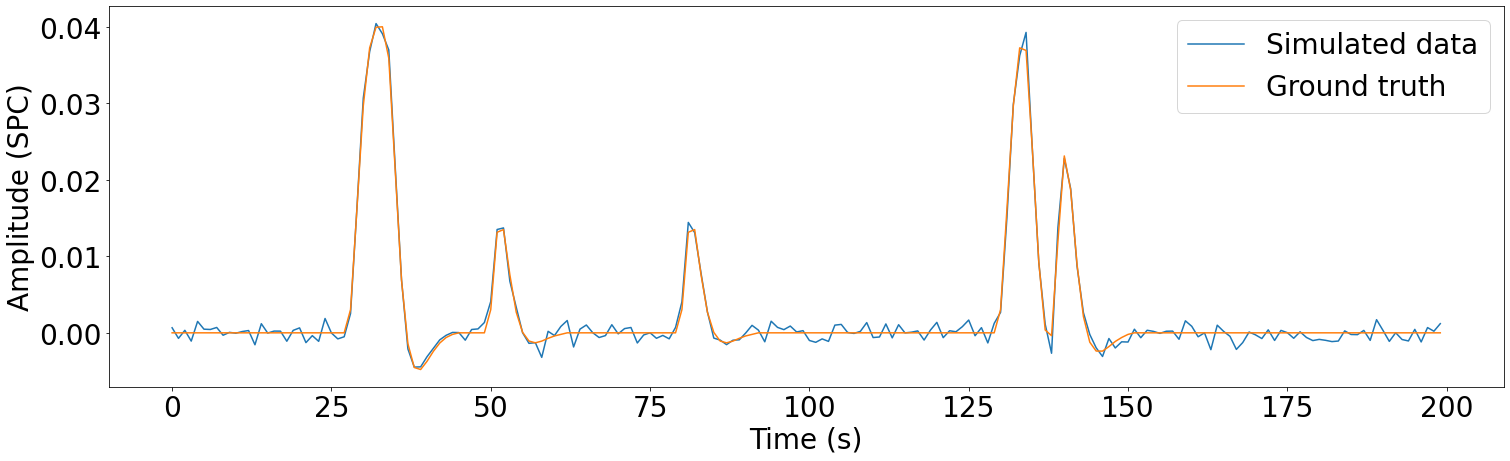

In [4]:
plt.figure(figsize=(25,7))
plt.plot(data[:, 0], label='Simulated data')
plt.plot(ground_truth_bold, label='Ground truth')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (SPC)')
plt.legend()
plt.show()

## Data parameters for TA

In [5]:
params = {'tr': 2, 'cost_save': True, 'te': [0]} # This is for TA (to follow MATLAB code structure)

## Compare TA filter with PFM haemodynamic response function

/Users/enekourunuela/pfm_vs_ta/code/Scripts/total_activation.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  fil[i + 1] = (-1) ** (i + 1) * np.sum(np.exp(np.sum(combs_result, axis=1)))


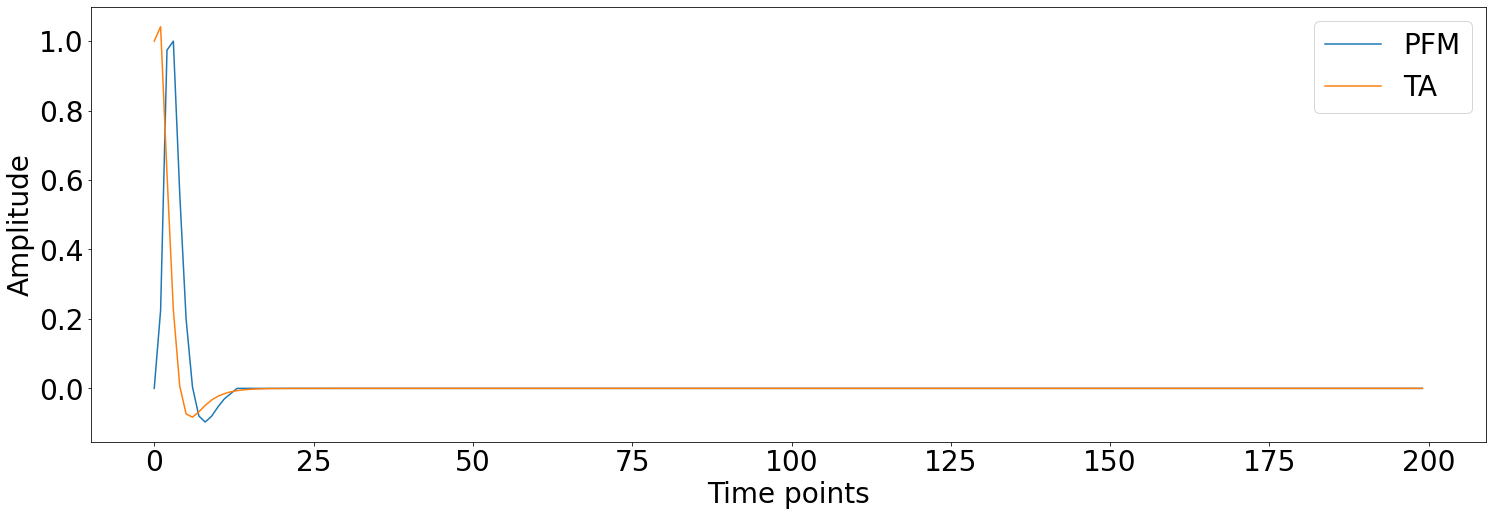

In [6]:
test_data = np.zeros(nscans)
test_data[int(0/params['tr'])] = 1

# Generate design matrix (shifted HRFs) for PFM with the spike model
hrf_matrix = HRFMatrix(TR=params['tr'], TE=params['te'], nscans=nscans, r2only=True, has_integrator=False, is_afni=True, lop_hrf='SPMG1')
hrf_matrix.generate_hrf()
hrf = hrf_matrix.X_hrf_norm

# Generate hrf filter for TA with spike model
params['model'] = 'spike'
params['f_analyze'], params['f_recons'], params['maxeig'] = hrf_filters(params['tr'], condition=params['model'], condition2='spmhrf')
n = params['f_recons']['den'][0]
d = [np.array(params['f_recons']['num']), 1]

bold_pfm = np.dot(hrf, test_data)
bold_ta = np.real(ta_filter(n, d, test_data.T, 'normal', nscans))

plt.figure(figsize=(25,8))
plt.plot(bold_pfm, label='PFM')
plt.plot(bold_ta, label='TA')
plt.xlabel('Time points')
plt.ylabel('Amplitude')
plt.legend()

## Create convolution matrix with hrf used in TA (fair comparison between algorithms)

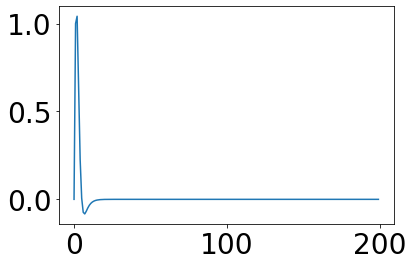

In [7]:
append_2 = 2*nscans - len(bold_ta)
temp = np.append(bold_ta, np.zeros(append_2))
for i in range(nscans-1):
    foo = np.append(np.zeros(i+1), bold_ta)
    append_2 = 2*nscans - len(foo)
    foo = np.append(foo, np.zeros(append_2))
    temp = np.column_stack((temp, foo))

hrf = temp[:nscans, :nscans]
plt.plot(hrf[:, 1])

## Runs spike model PFM and TA on every voxel
## It runs LARS on PFM first, then uses the lambdas from LARS on TA.

In [8]:
# Generate hrf filter for TA with spike model
params['model'] = 'spike'
params['f_analyze'], params['f_recons'], params['maxeig'] = hrf_filters(params['tr'], condition=params['model'])
n = params['f_analyze']['num']
d = params['f_analyze']['den']

# Define the number of lambdas in LARS (relative the length of time series), i.e. no need to compute solutions close to OLS
nlambdas = int(nscans)
min_coeff_amplitude = 1e-3

for vox_idx in range(1): #range(nvoxels):
    print(f'Running LARS for PFM on voxel {vox_idx + 1} of {nvoxels}...')
    
    y = data[:, vox_idx]
    y = y[:, np.newaxis]
    
    pfm_max_lambda = np.max(np.dot(hrf.T, y))
    print(f'PFM max lambda: {pfm_max_lambda}')
    # LARS path
    lambdas_pfm_spike, _, pfm_spike_coef_path = lars_path(hrf, np.squeeze(y), method = 'lasso', Gram = np.dot(hrf.T, hrf),
                                                          Xy = np.dot(hrf.T, np.squeeze(y)), max_iter = nlambdas-1, eps=1e-9)
    
    # Multiply lambdas by nscans due to LARS implementation in scikit learn 
    lambdas_pfm_spike *= nscans
    pfm_spike_coef_path[abs(pfm_spike_coef_path) < min_coeff_amplitude] = 0
    
    # Compute residuals for model selection criteria (BIC and AIC)
    L2res_pfm_spike = np.sum((np.repeat(y, nlambdas, axis=-1) - np.dot(hrf, pfm_spike_coef_path))**2, axis=0)
    # BIC regularization curve
    bic_pfm_spike = nscans*np.log(L2res_pfm_spike) + np.log(nscans)*np.count_nonzero(pfm_spike_coef_path, axis=0)
    # AIC regularization curve
    aic_pfm_spike = nscans*np.log(L2res_pfm_spike) + 2*np.count_nonzero(pfm_spike_coef_path, axis=0)
    
    # Compute TA for the same regularization path (i.e. same lambdas)
    print(f'Calculating regularization path for TA on voxel {vox_idx + 1} of {nvoxels}...')
    #ta_max_lambda = np.max(ta_filter(n, d, y, 'transpose', nscans))
    ta_max_lambda = abs(np.max(y)/np.min(ta_filter(n, d, y, 'transpose', nscans))*params['maxeig'])
    print(f'TA max lambda: {ta_max_lambda}')
    #lambdas_ta_spike = np.geomspace(ta_max_lambda, 0.1*ta_max_lambda, nlambdas)
    lambdas_ta_spike = lambdas_pfm_spike.copy()
    ta_spike_coef_path = np.zeros(pfm_spike_coef_path.shape) # Shape: nscans x nlambdas
    for lambda_idx in range(nlambdas):
        ta_coefs, _ = ta(y, params, lambd=lambdas_ta_spike[lambda_idx])
        ta_spike_coef_path[:, lambda_idx] = np.squeeze(ta_coefs)
        
    ta_spike_coef_path[abs(ta_spike_coef_path) < min_coeff_amplitude] = 0
    
    # Compute residuals for model selection criteria (BIC and AIC)
    L2res_ta = np.sum((np.repeat(y, nlambdas, axis=-1) - np.dot(hrf, ta_spike_coef_path))**2, axis=0)
    bic_ta_spike = nscans*np.log(L2res_ta) + np.log(nscans)*np.count_nonzero(ta_spike_coef_path, axis=0)
    aic_ta_spike = nscans*np.log(L2res_ta) + 2*np.count_nonzero(ta_spike_coef_path, axis=0)
    
    print(f'Regularization path of voxel {vox_idx + 1} calculated')

# Find the optimal lambdas for each method (PFM, TA) and each selection criteria (BIC, AIC)    
bic_pfm_spike_idx = np.argmin(bic_pfm_spike)
aic_pfm_spike_idx = np.argmin(aic_pfm_spike)
bic_ta_spike_idx = np.argmin(bic_ta_spike)
aic_ta_spike_idx = np.argmin(aic_ta_spike)

/Users/enekourunuela/pfm_vs_ta/code/Scripts/total_activation.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  fil[i + 1] = (-1) ** (i + 1) * np.sum(np.exp(np.sum(combs_result, axis=1)))


Running LARS for PFM on voxel 1 of 1...
PFM max lambda: 0.1119024612365978
Calculating regularization path for TA on voxel 1 of 1...
TA max lambda: 27.07060191667425
Regularization path of voxel 1 calculated


## Plot comparison of spike model regularization path

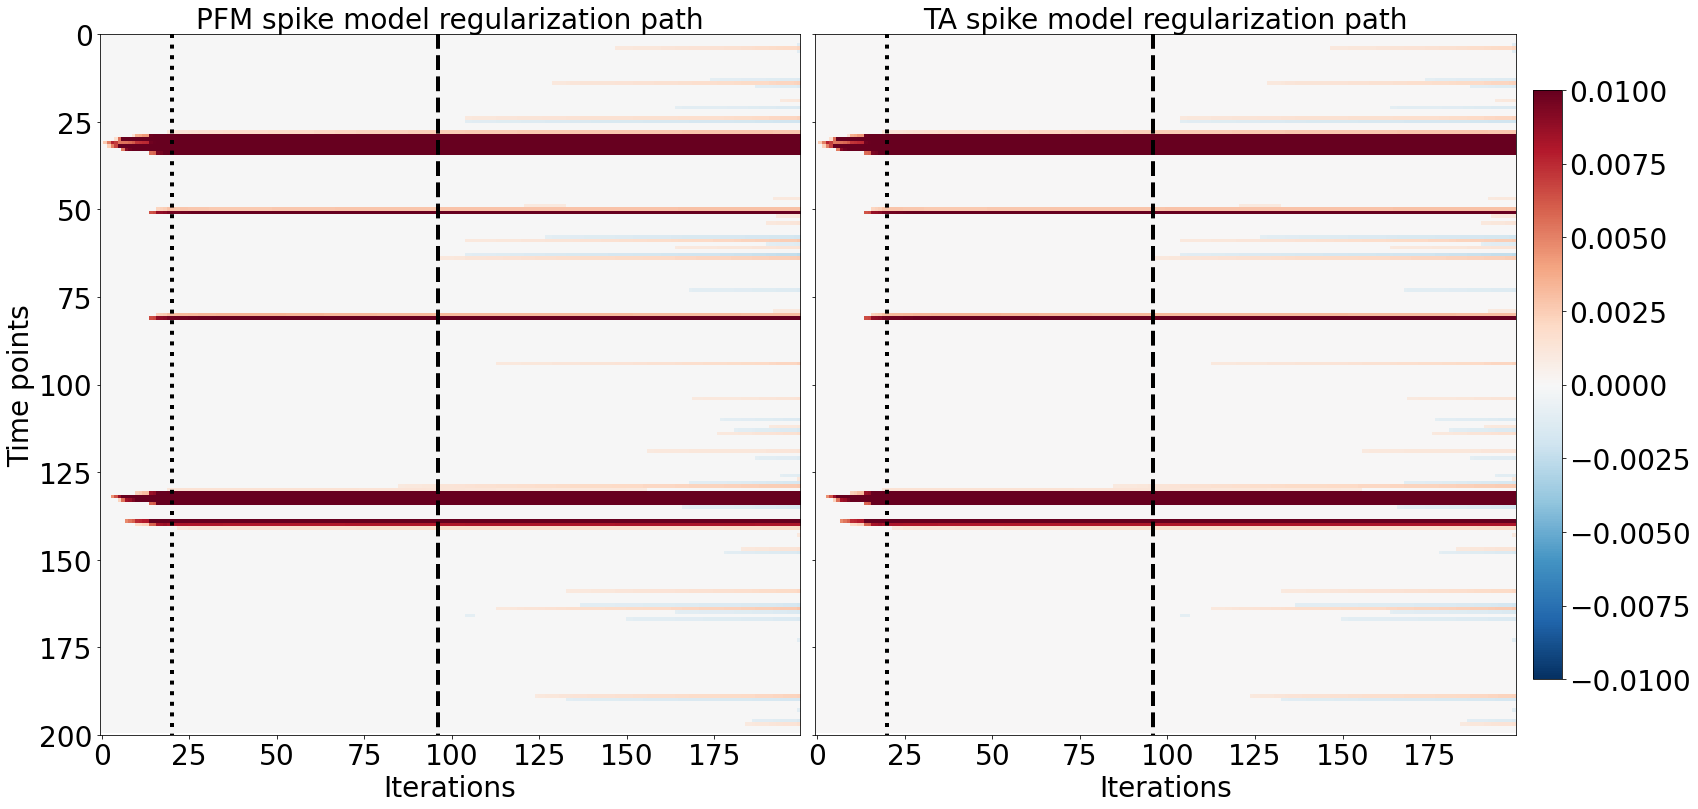

In [9]:
_, cD1 = wavedec(y, 'db3', level=1, axis=0)
noise_estimate = np.median(abs(cD1 - np.median(cD1))) / 0.8095
mad_idx = np.where(noise_estimate > np.sqrt(L2res_pfm_spike/nscans))[0][0]

max_scale = 0.01
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(25,12))
im = ax1.imshow(pfm_spike_coef_path, cmap='RdBu_r', vmin=-max_scale, vmax=max_scale)
ax1.vlines(x=bic_pfm_spike_idx, ymin=0, ymax=nscans, color='black', linestyles='dashed', label='BIC', linewidth=4)
ax1.vlines(x=mad_idx, ymin=0, ymax=nscans, color='black', linestyles='dotted', label='BIC', linewidth=4)
#ax1.vlines(x=aic_pfm_spike_idx, ymin=0, ymax=nscans, color='black', linestyles='dashdot', label='AIC')
ax1.set_ylim([nscans, 0])
# ax1.legend()
ax1.set(xlabel='Iterations', ylabel='Time points')
ax1.set_title('PFM spike model regularization path')
ax2.imshow(ta_spike_coef_path, cmap='RdBu_r', vmin=-max_scale, vmax=max_scale)
ax2.vlines(x=bic_ta_spike_idx, ymin=0, ymax=nscans, color='black', linestyles='dashed', label='BIC', linewidth=4)
ax2.vlines(x=mad_idx, ymin=0, ymax=nscans, color='black', linestyles='dotted', label='BIC', linewidth=4)
# ax2.vlines(x=aic_ta_spike_idx, ymin=0, ymax=nscans, color='black', linestyles='dashdot', label='AIC')
ax2.set_ylim([nscans, 0])
# ax2.legend()
ax2.set(xlabel='Iterations')
ax2.set_title('TA spike model regularization path')
plt.tight_layout()
fig.colorbar(im, ax=[ax1, ax2], shrink=0.77, pad=0.01)

Text(0, 0.5, '$\\lambda$')

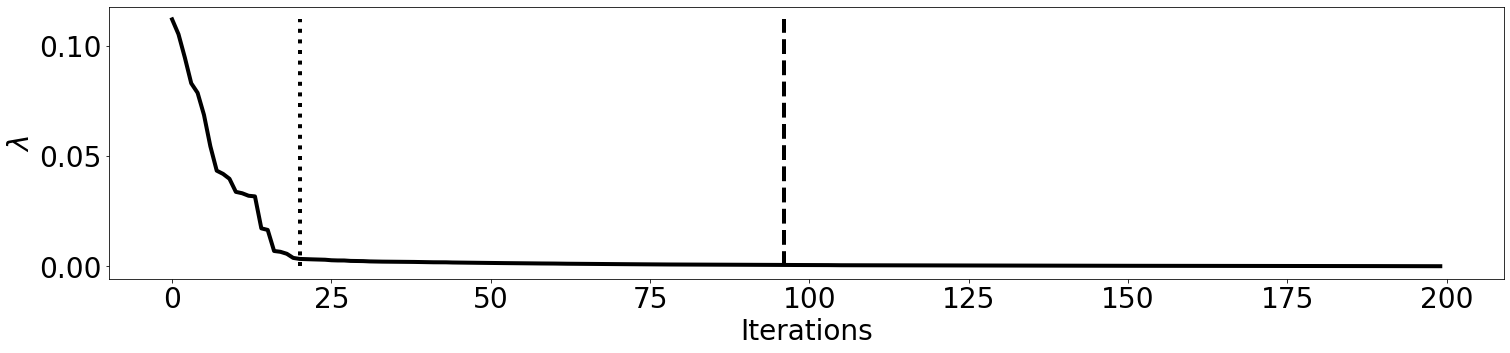

In [10]:
fig = plt.figure(figsize=(25,5))
plt.plot(lambdas_pfm_spike, color="black", linewidth=4)
plt.vlines(x=bic_pfm_spike_idx, ymin=0, ymax=lambdas_pfm_spike[0], color='black', linestyles='dashed', label='BIC', linewidth=4)
plt.vlines(x=mad_idx, ymin=0, ymax=lambdas_pfm_spike[0], color='black', linestyles='dotted', label='BIC', linewidth=4)
plt.xlabel("Iterations")
plt.ylabel("$\lambda$")

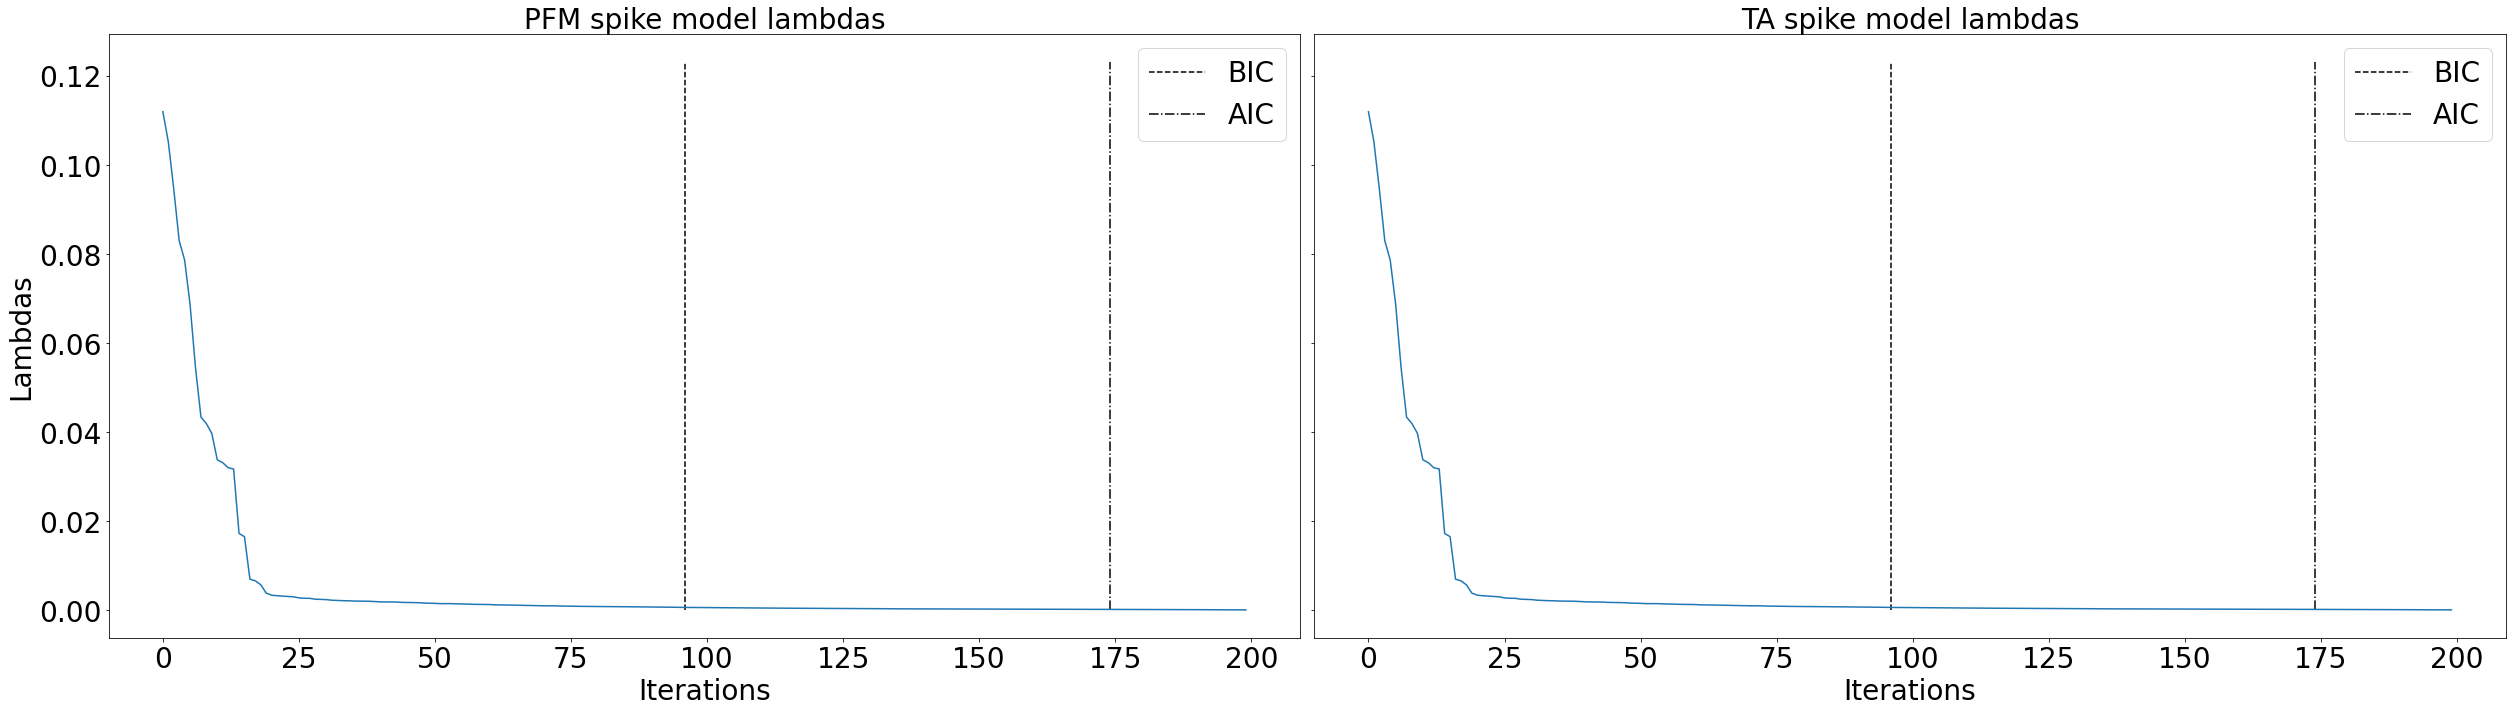

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(35,10))
ax1.plot(lambdas_pfm_spike)
ax1.vlines(x=bic_pfm_spike_idx, ymin=0, ymax=1.1*np.max(lambdas_pfm_spike), color='black', linestyles='dashed', label='BIC')
ax1.vlines(x=aic_pfm_spike_idx, ymin=0, ymax=1.1*np.max(lambdas_pfm_spike), color='black', linestyles='dashdot', label='AIC')
ax1.legend()
ax1.set(xlabel='Iterations', ylabel='Lambdas')
ax1.set_title('PFM spike model lambdas')
ax2.plot(lambdas_ta_spike)
ax2.vlines(x=bic_ta_spike_idx, ymin=0, ymax=1.1*np.max(lambdas_ta_spike), color='black', linestyles='dashed', label='BIC')
ax2.vlines(x=aic_ta_spike_idx, ymin=0, ymax=1.1*np.max(lambdas_ta_spike), color='black', linestyles='dashdot', label='AIC')
ax2.legend()
ax2.set(xlabel='Iterations')
ax2.set_title('TA spike model lambdas')

plt.tight_layout()
plt.show()

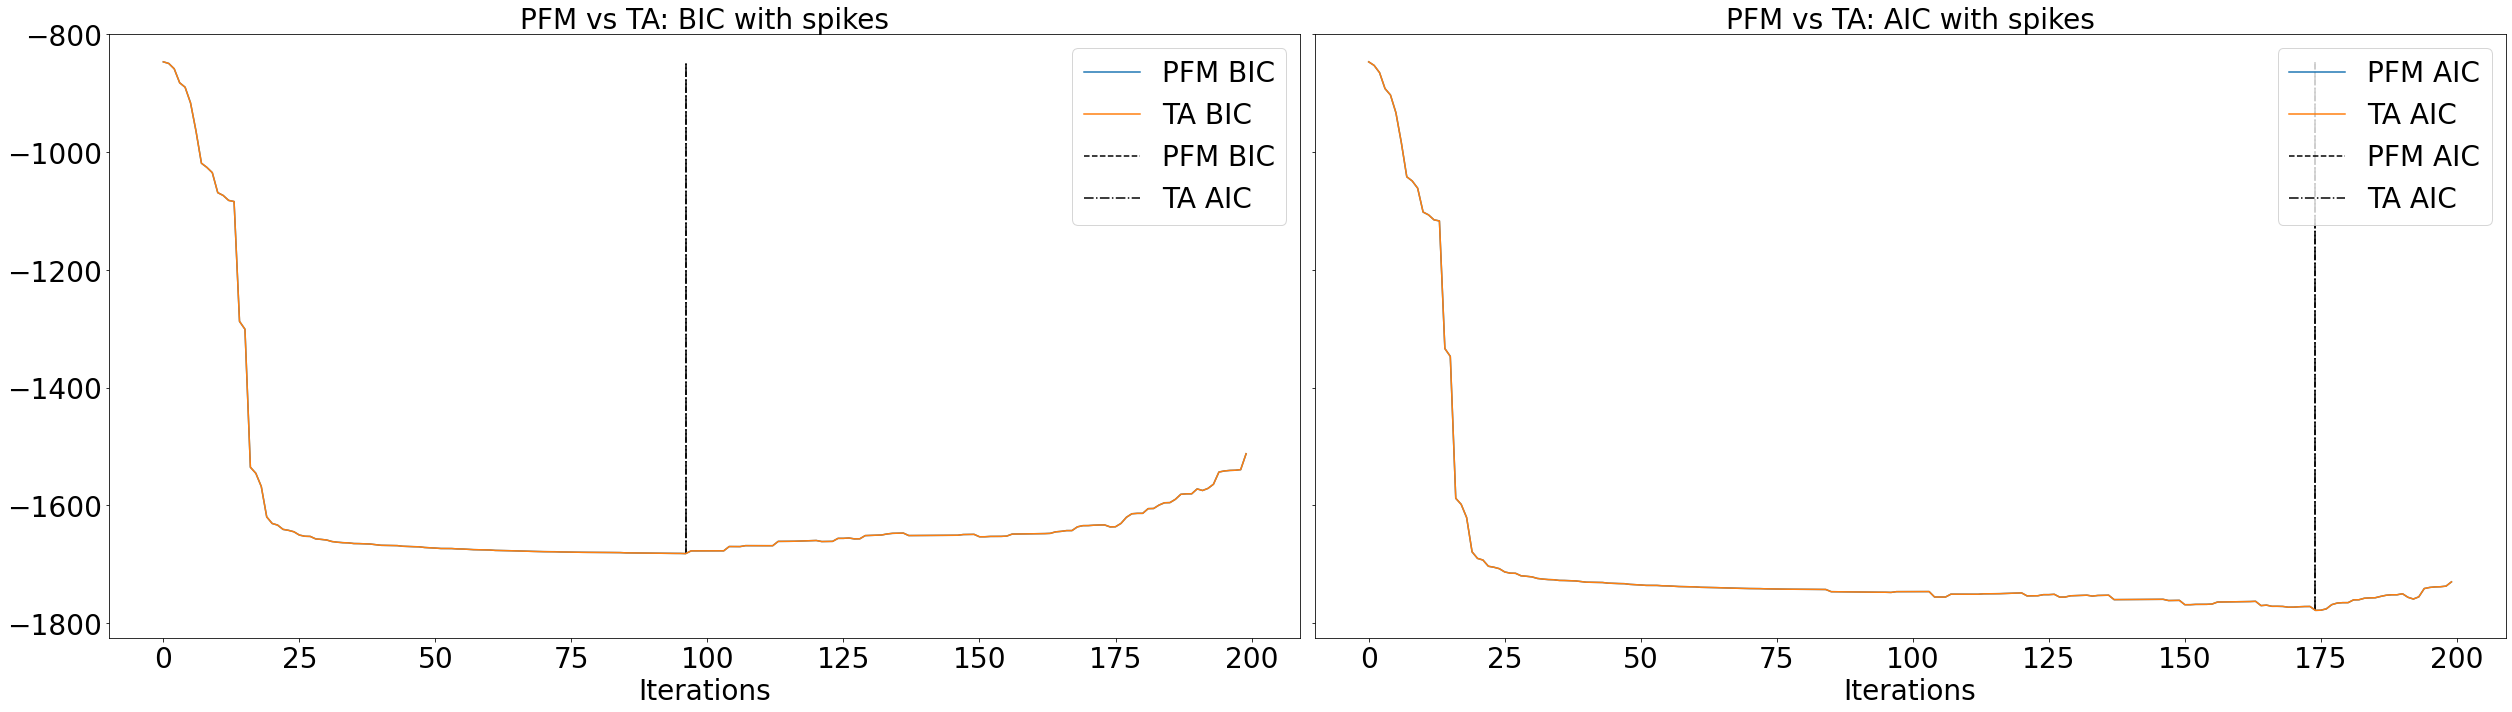

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(35,10))
ax1.plot(bic_pfm_spike, label='PFM BIC')
ax1.plot(bic_ta_spike, label='TA BIC')
ax1.vlines(x=bic_pfm_spike_idx, ymin=np.min(bic_pfm_spike), ymax=np.max(bic_pfm_spike), color='black', linestyles='dashed', label='PFM BIC')
ax1.vlines(x=bic_ta_spike_idx, ymin=np.min(bic_ta_spike), ymax=np.max(bic_ta_spike), color='black', linestyles='dashdot', label='TA AIC')
ax1.set(xlabel='Iterations')
ax1.set_title('PFM vs TA: BIC with spikes')
ax1.legend()
ax2.plot(aic_pfm_spike, label='PFM AIC')
ax2.plot(aic_ta_spike, label='TA AIC')
ax2.vlines(x=aic_pfm_spike_idx, ymin=np.min(aic_pfm_spike), ymax=np.max(aic_pfm_spike), color='black', linestyles='dashed', label='PFM AIC')
ax2.vlines(x=aic_ta_spike_idx, ymin=np.min(aic_ta_spike), ymax=np.max(aic_ta_spike), color='black', linestyles='dashdot', label='TA AIC')
ax2.set(xlabel='Iterations')
ax2.legend()
ax2.set_title('PFM vs TA: AIC with spikes')

plt.tight_layout()
plt.show()

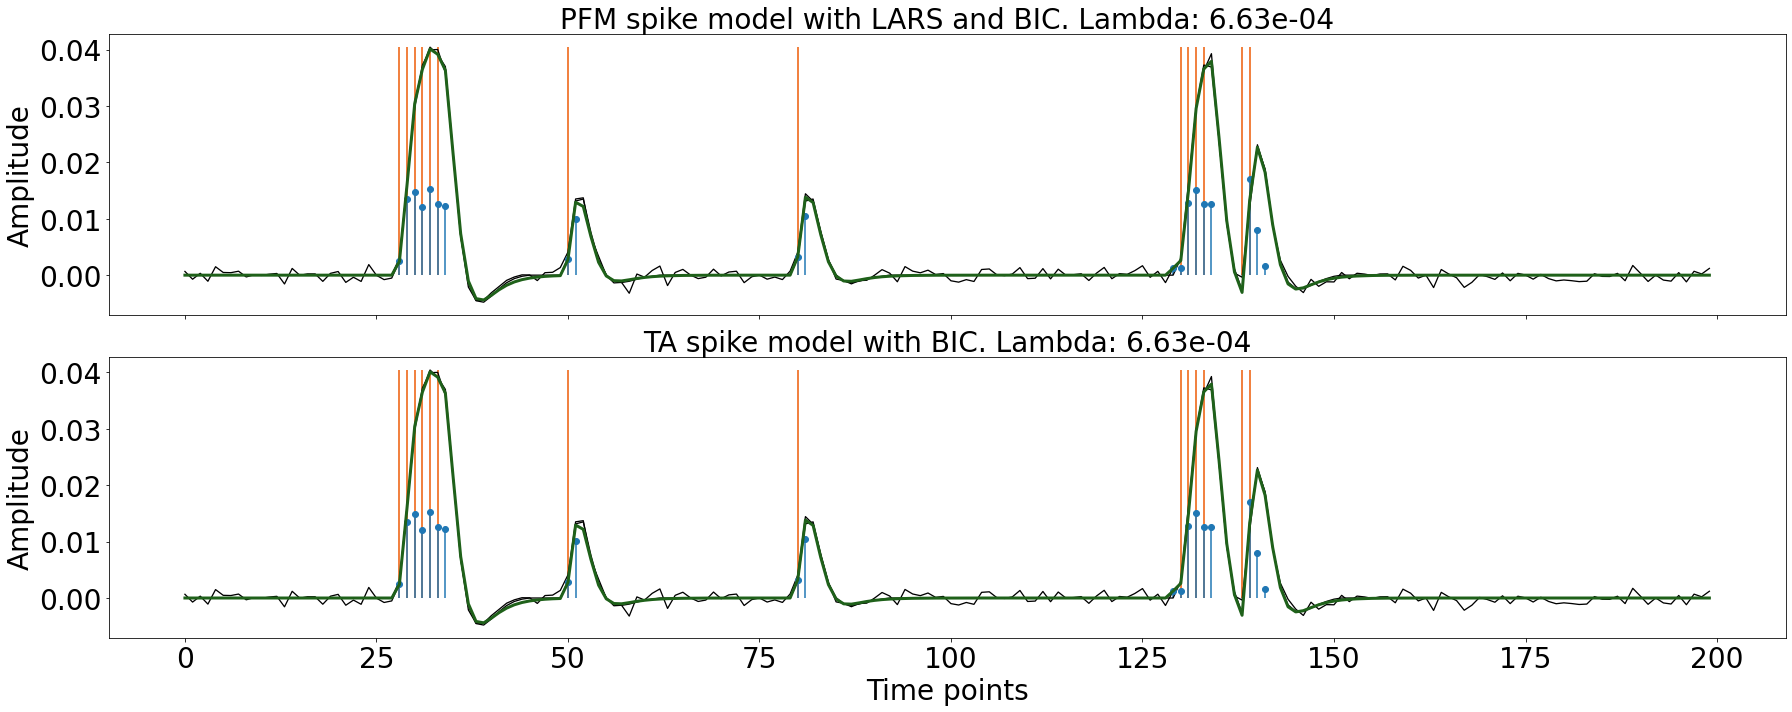

In [13]:
# Get results
pfm_2_plot = pfm_spike_coef_path[:,bic_pfm_spike_idx]
ta_2_plot = ta_spike_coef_path[:,bic_ta_spike_idx]

# Get fit.
pfm_2_plot_fit = np.dot(hrf, pfm_2_plot)
ta_2_plot_fit = np.dot(hrf, ta_2_plot)

# Make zeros nan to avoid plotting them.
pfm_2_plot[abs(pfm_2_plot) < min_coeff_amplitude] = np.nan
ta_2_plot[abs(ta_2_plot) < min_coeff_amplitude] = np.nan

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(25,10))
ax1.plot(y, color='black', linewidth=1.3, label='Simulation')
ax1.plot(ground_truth_bold, color='black', linewidth=1.3, label='Ground truth BOLD')
ax1.vlines(np.where(ground_truth_beta != 0)[0], ymin=0, ymax=np.max(data), color='#f17c37', linewidth=1.9, label='Ground truth betas')
ax1.stem(pfm_2_plot, label='PFM beta', use_line_collection=True, basefmt=" ")
ax1.plot(pfm_2_plot_fit, color='#1f611a', label='PFM fit', linewidth=3)
ax1.set(ylabel='Amplitude')
ax1.set_title('PFM spike model with LARS and BIC. Lambda: {:.2e}'.format(lambdas_pfm_spike[bic_pfm_spike_idx]))
# ax1.legend()
ax2.plot(y, color='black', linewidth=1.3, label='Simulation')
ax2.plot(ground_truth_bold, color='black', linewidth=1.3, label='Ground truth BOLD')
ax2.vlines(np.where(ground_truth_beta != 0)[0], ymin=0, ymax=np.max(data), color='#f17c37', linewidth=1.9, label='Ground truth betas')
ax2.stem(ta_2_plot, label='TA beta', use_line_collection=True, basefmt=" ")
ax2.plot(ta_2_plot_fit, color='#1f611a', label='TA fit', linewidth=3)
ax2.set(xlabel='Time points', ylabel='Amplitude')
ax2.set_title('TA spike model with BIC. Lambda: {:.2e}'.format(lambdas_ta_spike[bic_pfm_spike_idx]))
# ax2.legend()

plt.tight_layout()
plt.show()

In [14]:
# Generate hrf filter for TA with block model
params['model'] = 'block'
params['f_analyze'], params['f_recons'], params['maxeig'] = hrf_filters(params['tr'], condition=params['model'])
n = params['f_analyze']['num']
d = params['f_analyze']['den']
params['NitTemp'] = 1000

hrf_block = np.dot(hrf, np.tril(np.ones(nscans)))
nlambdas = int(nscans)
min_coeff_amplitude = 1e-3

for vox_idx in range(1): #range(nvoxels):
    print(f'Running LARS for PFM on voxel {vox_idx + 1} of {nvoxels}...')
    
    y = data[:, vox_idx]
    y = y[:, np.newaxis]
    
    pfm_max_lambda = np.max(np.dot(hrf_block.T, y))
    print(f'PFM max lambda: {pfm_max_lambda}')
    # LARS path
    lambdas_pfm_block, _, pfm_block_coef_path = lars_path(hrf_block, np.squeeze(y), method = 'lasso', Gram = np.dot(hrf_block.T, hrf_block),
                                                          Xy = np.dot(hrf_block.T, np.squeeze(y)), max_iter = nlambdas-1, eps=1e-9)
    
    lambdas_pfm_block *= nscans
    pfm_block_coef_path[abs(pfm_block_coef_path) < min_coeff_amplitude] = 0
    pfm_block_fit = np.zeros(pfm_block_coef_path.shape) # Shape: nscans x nlambdas
    for lambda_idx in range(nlambdas):
        pfm_block_beta, _ = debiasing_int(pfm_block_coef_path[:, lambda_idx], hrf, data, True)
        pfm_block_fit[:, lambda_idx] = np.squeeze(np.dot(hrf, pfm_block_beta))
    
    # Residuals
    L2res_pfm_block = np.sum((np.repeat(y, nlambdas, axis=-1) - pfm_block_fit)**2, axis=0)
    bic_pfm_block = nscans*np.log(L2res_pfm_block) + np.log(nscans)*np.count_nonzero(pfm_block_coef_path, axis=0)
    aic_pfm_block = nscans*np.log(L2res_pfm_block) + 2*np.count_nonzero(pfm_block_coef_path, axis=0)
    
    # Calculates regularization path for TA
    print(f'Calculating regularization path for TA on voxel {vox_idx + 1} of {nvoxels}...')
    #ta_max_lambda = np.max(ta_filter(n, d, y, 'transpose', nscans))
    ta_max_lambda = abs(np.max(y)/np.min(ta_filter(n, d, y, 'transpose', nscans))*params['maxeig'])
    print(f'TA max lambda: {ta_max_lambda}')
#    lambdas_ta_block = np.geomspace(ta_max_lambda, 0.1*ta_max_lambda, nlambdas)
    lambdas_ta_block = lambdas_pfm_block.copy()
    ta_block_coef_path = np.zeros(pfm_block_coef_path.shape) # Shape: nscans x nlambdas
    ta_block_fit = np.zeros(pfm_block_coef_path.shape) # Shape: nscans x nlambdas
    for lambda_idx in range(nlambdas):
        ta_coefs, _ = ta(y, params, lambd=lambdas_ta_block[lambda_idx])
        ta_block_coef_path[:, lambda_idx] = np.squeeze(ta_coefs)
        ta_block_coef_path[abs(ta_block_coef_path) < min_coeff_amplitude] = 0
        ta_block_beta, _ = debiasing_int(ta_block_coef_path[:, lambda_idx], hrf, data, True)
        ta_block_fit[:, lambda_idx] = np.squeeze(np.dot(hrf, ta_block_beta))

    # Residuals
    L2res_ta = np.sum((np.repeat(y, nlambdas, axis=-1) - ta_block_fit)**2, axis=0)
    bic_ta_block = nscans*np.log(L2res_ta) + np.log(nscans)*np.count_nonzero(ta_block_coef_path, axis=0)
    aic_ta_block = nscans*np.log(L2res_ta) + 2*np.count_nonzero(ta_block_coef_path, axis=0)
    
    print(f'Regularization path of voxel {vox_idx + 1} calculated')


/Users/enekourunuela/pfm_vs_ta/code/Scripts/total_activation.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  fil[i + 1] = (-1) ** (i + 1) * np.sum(np.exp(np.sum(combs_result, axis=1)))


Running LARS for PFM on voxel 1 of 1...
PFM max lambda: 1.3040191605217664
Calculating regularization path for TA on voxel 1 of 1...
TA max lambda: 108.28215286788203
Regularization path of voxel 1 calculated


In [15]:
bic_pfm_block_idx = np.argmin(bic_pfm_block)
aic_pfm_block_idx = np.argmin(aic_pfm_block)
bic_ta_block_idx = np.argmin(bic_ta_block) #[10:]) + 10
aic_ta_block_idx = np.argmin(aic_ta_block) #[10:]) + 10
print(f'Optimal regularization for PFM with BIC is {lambdas_pfm_block[bic_pfm_block_idx]}, iteration: {bic_pfm_block_idx}')
print(f'Optimal regularization for PFM with AIC is {lambdas_pfm_block[aic_pfm_block_idx]}, iteration: {aic_pfm_block_idx}')
print(f'Optimal regularization for TA with BIC is {lambdas_ta_block[bic_ta_block_idx]}, iteration: {bic_ta_block_idx}')
print(f'Optimal regularization for TA with AIC is {lambdas_ta_block[aic_ta_block_idx]}, iteration: {aic_ta_block_idx}')

Optimal regularization for PFM with BIC is 0.0008459693064024929, iteration: 121
Optimal regularization for PFM with AIC is 0.0008459693064024929, iteration: 121
Optimal regularization for TA with BIC is 0.0008459693064024929, iteration: 121
Optimal regularization for TA with AIC is 0.0008459693064024929, iteration: 121


## Plot comparison of block model regularization path

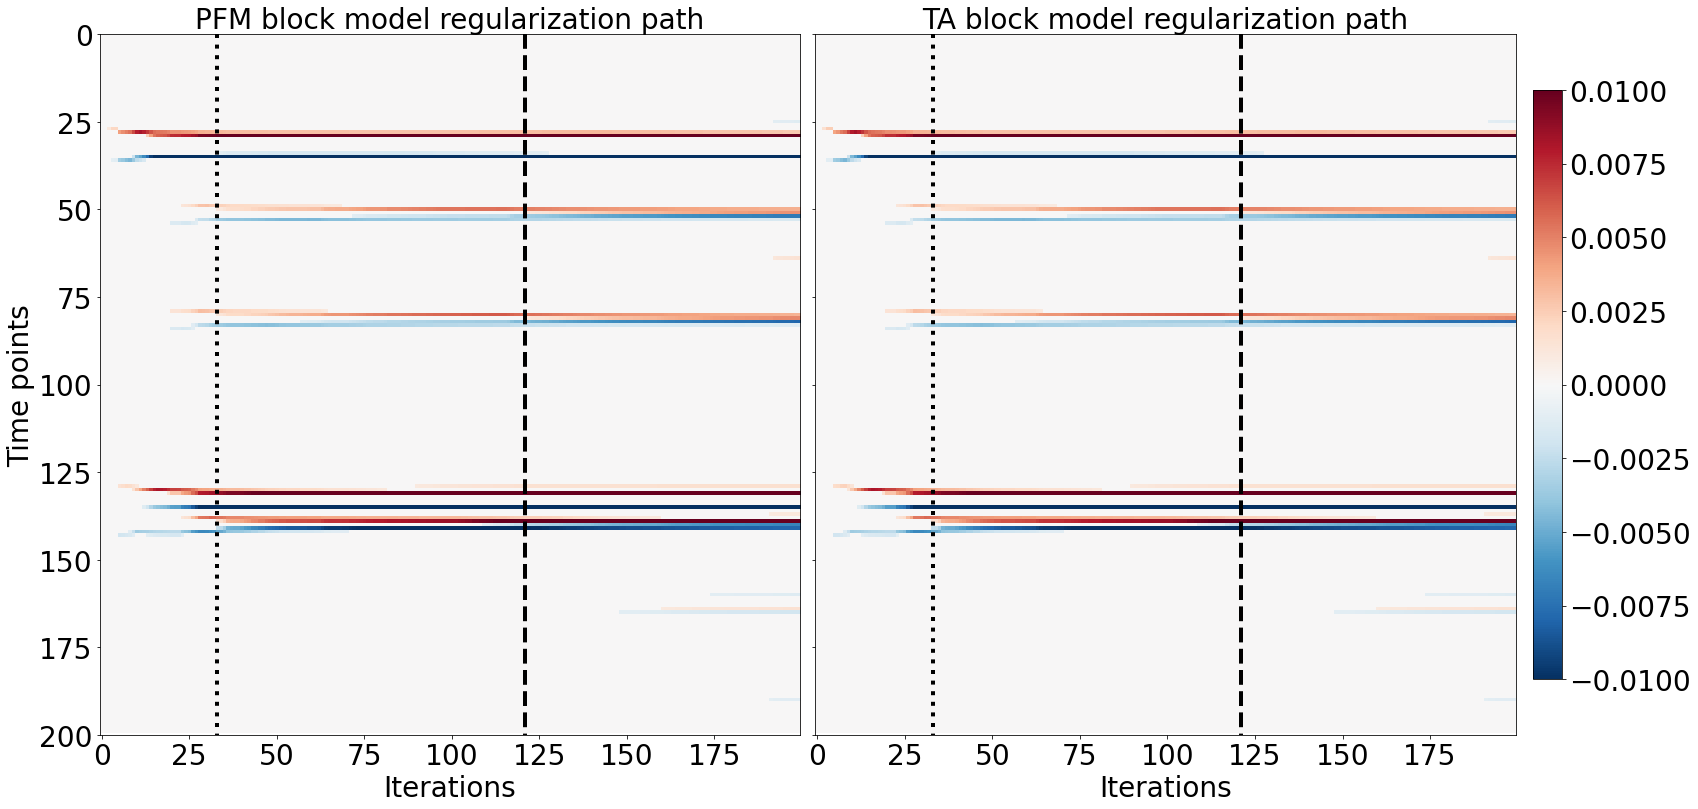

In [16]:
_, cD1 = wavedec(y, 'db3', level=1, axis=0)
noise_estimate = np.median(abs(cD1 - np.median(cD1))) / 0.8095
mad_idx = np.where(noise_estimate > np.sqrt(L2res_pfm_block/nscans))[0][0]

max_scale=0.01 # largest amplitude for visualization purposes
# TIP: saturate the plots (i.e. very small max_scale) in order to see 
# the erratic operations in TA in the largest lambdas (first iterations)
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(25,12))
im = ax1.imshow(pfm_block_coef_path, cmap='RdBu_r', vmin=-max_scale, vmax=max_scale)
ax1.vlines(x=bic_pfm_block_idx, ymin=0, ymax=nscans, color='black', linestyles='dashed', label='BIC', linewidth=4)
ax1.vlines(x=mad_idx, ymin=0, ymax=nscans, color='black', linestyles='dotted', label='BIC', linewidth=4)
# ax1.vlines(x=aic_pfm_block_idx, ymin=0, ymax=nscans, color='black', linestyles='dashdot', label='AIC')
ax1.set_ylim([nscans, 0])
# ax1.legend()
ax1.set(xlabel='Iterations', ylabel='Time points')
ax1.set_title('PFM block model regularization path')
ax2.imshow(ta_block_coef_path, cmap='RdBu_r', vmin=-max_scale, vmax=max_scale)
ax2.vlines(x=bic_ta_block_idx, ymin=0, ymax=nscans, color='black', linestyles='dashed', label='BIC', linewidth=4)
ax2.vlines(x=mad_idx, ymin=0, ymax=nscans, color='black', linestyles='dotted', label='BIC', linewidth=4)
# ax2.vlines(x=aic_ta_block_idx, ymin=0, ymax=nscans, color='black', linestyles='dashdot', label='AIC')
ax2.set_ylim([nscans, 0])
# ax2.legend()
ax2.set(xlabel='Iterations')
ax2.set_title('TA block model regularization path')
plt.tight_layout()
fig.colorbar(im, ax=[ax1, ax2], shrink=0.77, pad=0.01)

Text(0, 0.5, '$\\lambda$')

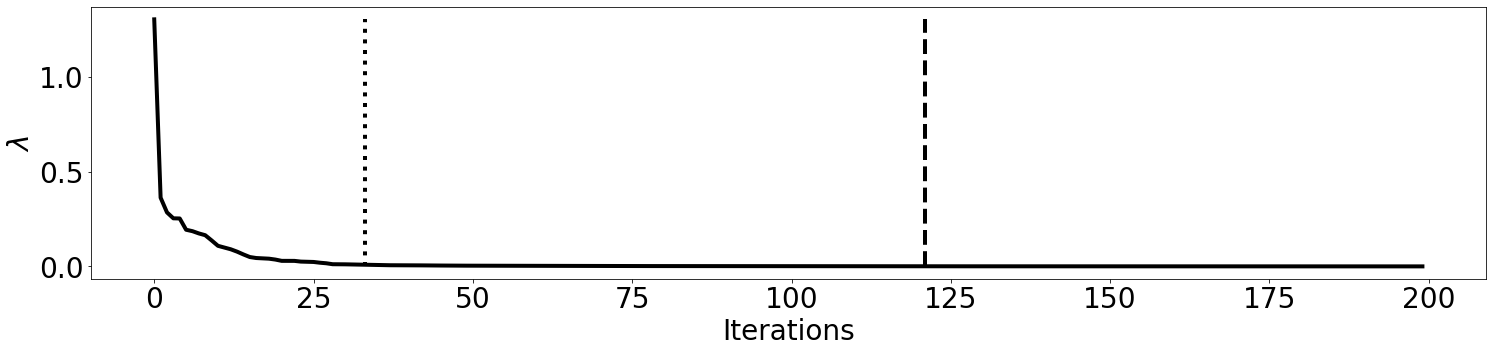

In [17]:
fig = plt.figure(figsize=(25,5))
plt.plot(lambdas_pfm_block, color="black", linewidth=4)
plt.vlines(x=bic_pfm_block_idx, ymin=0, ymax=lambdas_pfm_block[0], color='black', linestyles='dashed', label='BIC', linewidth=4)
plt.vlines(x=mad_idx, ymin=0, ymax=lambdas_pfm_block[0], color='black', linestyles='dotted', label='BIC', linewidth=4)
plt.xlabel("Iterations")
plt.ylabel("$\lambda$")

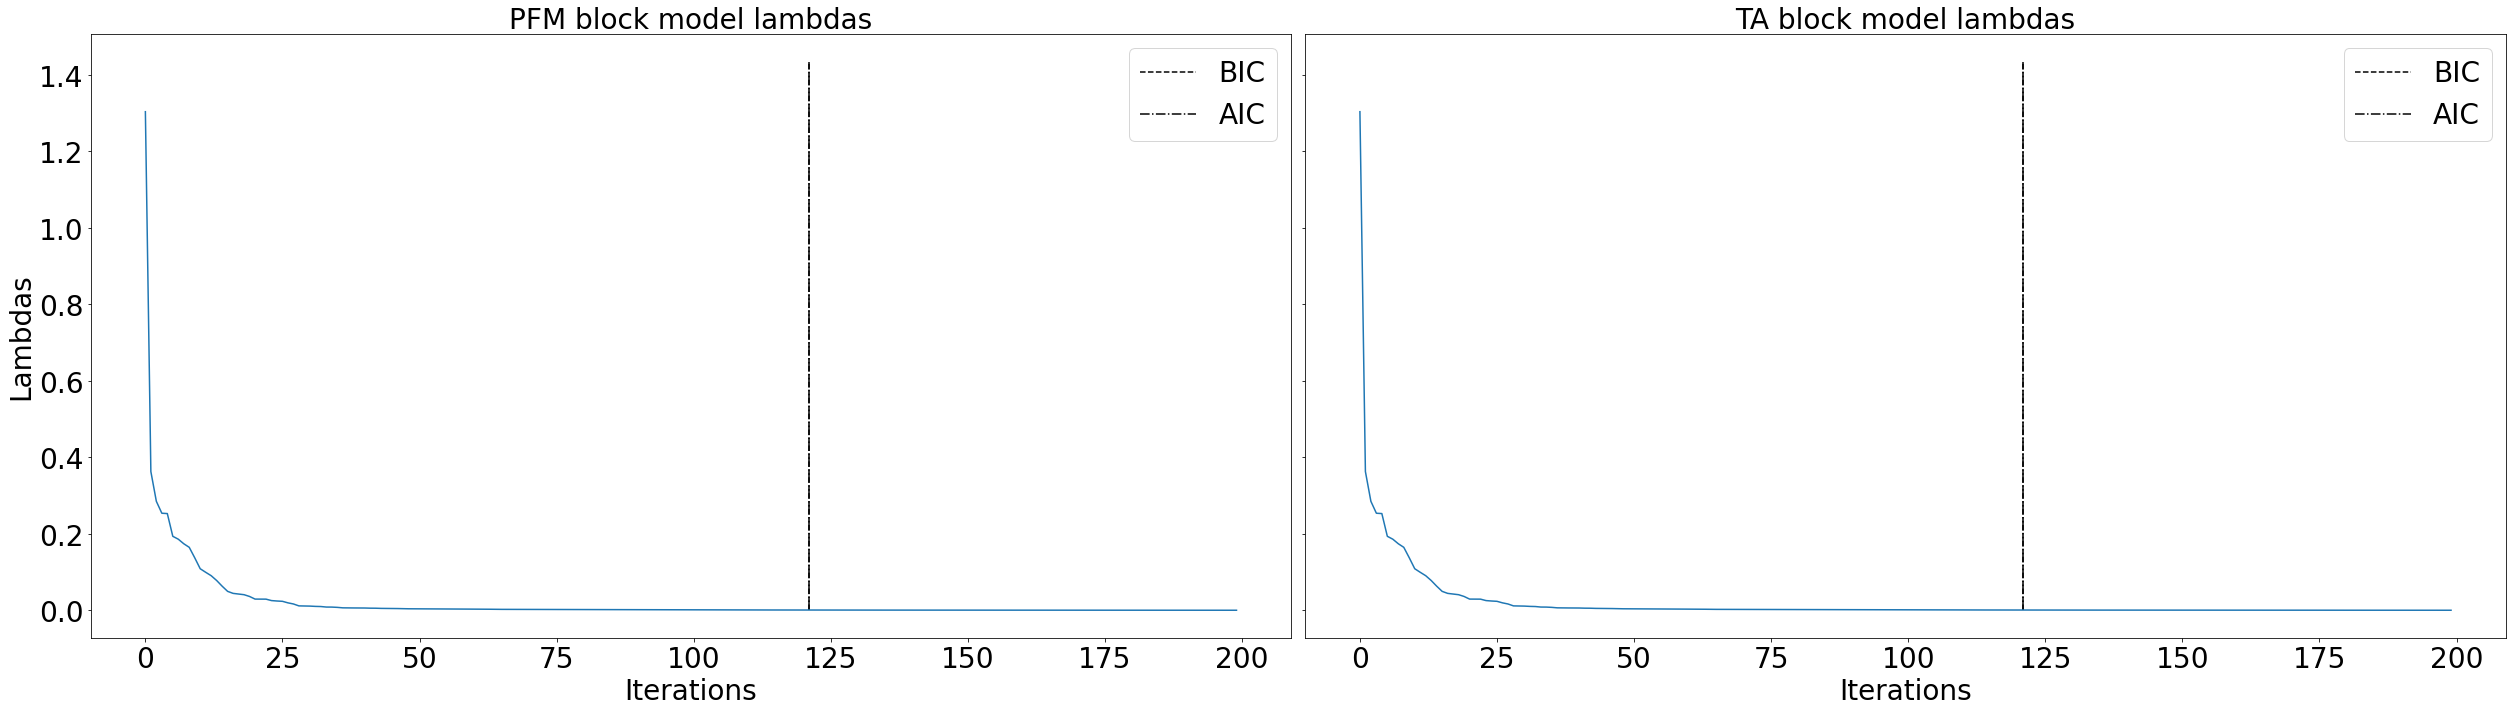

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(35,10))
ax1.plot(lambdas_pfm_block)
ax1.vlines(x=bic_pfm_block_idx, ymin=0, ymax=1.1*np.max(lambdas_pfm_block), color='black', linestyles='dashed', label='BIC')
ax1.vlines(x=aic_pfm_block_idx, ymin=0, ymax=1.1*np.max(lambdas_pfm_block), color='black', linestyles='dashdot', label='AIC')
ax1.legend()
ax1.set(xlabel='Iterations', ylabel='Lambdas')
ax1.set_title('PFM block model lambdas')
ax2.plot(lambdas_ta_block)
ax2.vlines(x=bic_ta_block_idx, ymin=0, ymax=1.1*np.max(lambdas_ta_block), color='black', linestyles='dashed', label='BIC')
ax2.vlines(x=aic_ta_block_idx, ymin=0, ymax=1.1*np.max(lambdas_ta_block), color='black', linestyles='dashdot', label='AIC')
ax2.legend()
ax2.set(xlabel='Iterations')
ax2.set_title('TA block model lambdas')

plt.tight_layout()
plt.show()

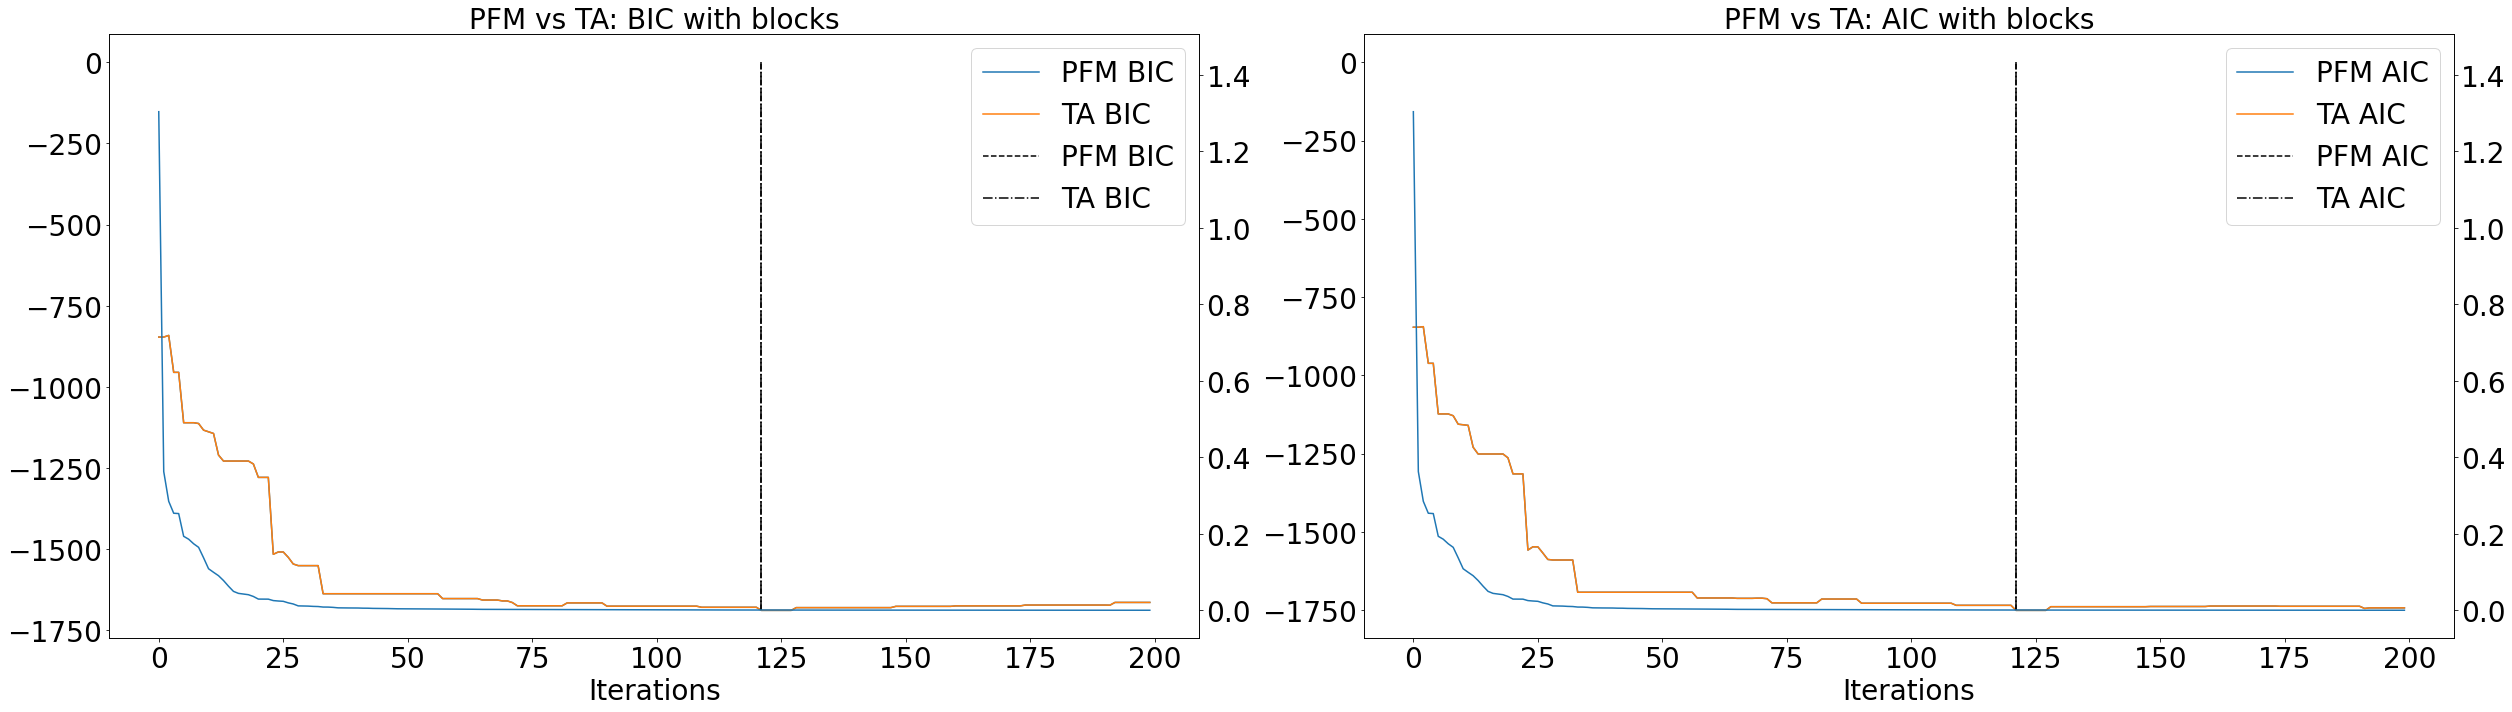

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(35,10))
ax1.plot(bic_pfm_block, label='PFM BIC')
ax1.plot(bic_ta_block, label='TA BIC')
ax1.vlines(x=bic_pfm_block_idx, ymin=0, ymax=1.1*np.max(lambdas_pfm_block), color='black', linestyles='dashed', label='PFM BIC')
ax1.vlines(x=bic_ta_block_idx, ymin=0, ymax=1.1*np.max(lambdas_ta_block), color='black', linestyles='dashdot', label='TA BIC')
ax1.set(xlabel='Iterations')
ax1.set_title('PFM vs TA: BIC with blocks')
ax1.legend()
ax2.plot(aic_pfm_block, label='PFM AIC')
ax2.plot(aic_ta_block, label='TA AIC')
ax2.vlines(x=aic_pfm_block_idx, ymin=0, ymax=1.1*np.max(lambdas_pfm_block), color='black', linestyles='dashed', label='PFM AIC')
ax2.vlines(x=aic_ta_block_idx, ymin=0, ymax=1.1*np.max(lambdas_ta_block), color='black', linestyles='dashdot', label='TA AIC')
ax2.set(xlabel='Iterations')
ax2.legend()
ax2.set_title('PFM vs TA: AIC with blocks')

ax3 = ax1.twinx()
ax4 = ax2.twinx()
ax3.plot(lambdas_pfm_block)
ax3.vlines(x=bic_pfm_block_idx, ymin=0, ymax=1.1*np.max(lambdas_pfm_block), color='black', linestyles='dashed', label='PFM BIC')
ax3.vlines(x=bic_ta_block_idx, ymin=0, ymax=1.1*np.max(lambdas_ta_block), color='black', linestyles='dashdot', label='TA BIC')

ax4.plot(lambdas_ta_block)
ax4.vlines(x=aic_pfm_block_idx, ymin=0, ymax=1.1*np.max(lambdas_pfm_block), color='black', linestyles='dashed', label='PFM AIC')
ax4.vlines(x=aic_ta_block_idx, ymin=0, ymax=1.1*np.max(lambdas_ta_block), color='black', linestyles='dashdot', label='TA AIC')



plt.tight_layout()
plt.show()

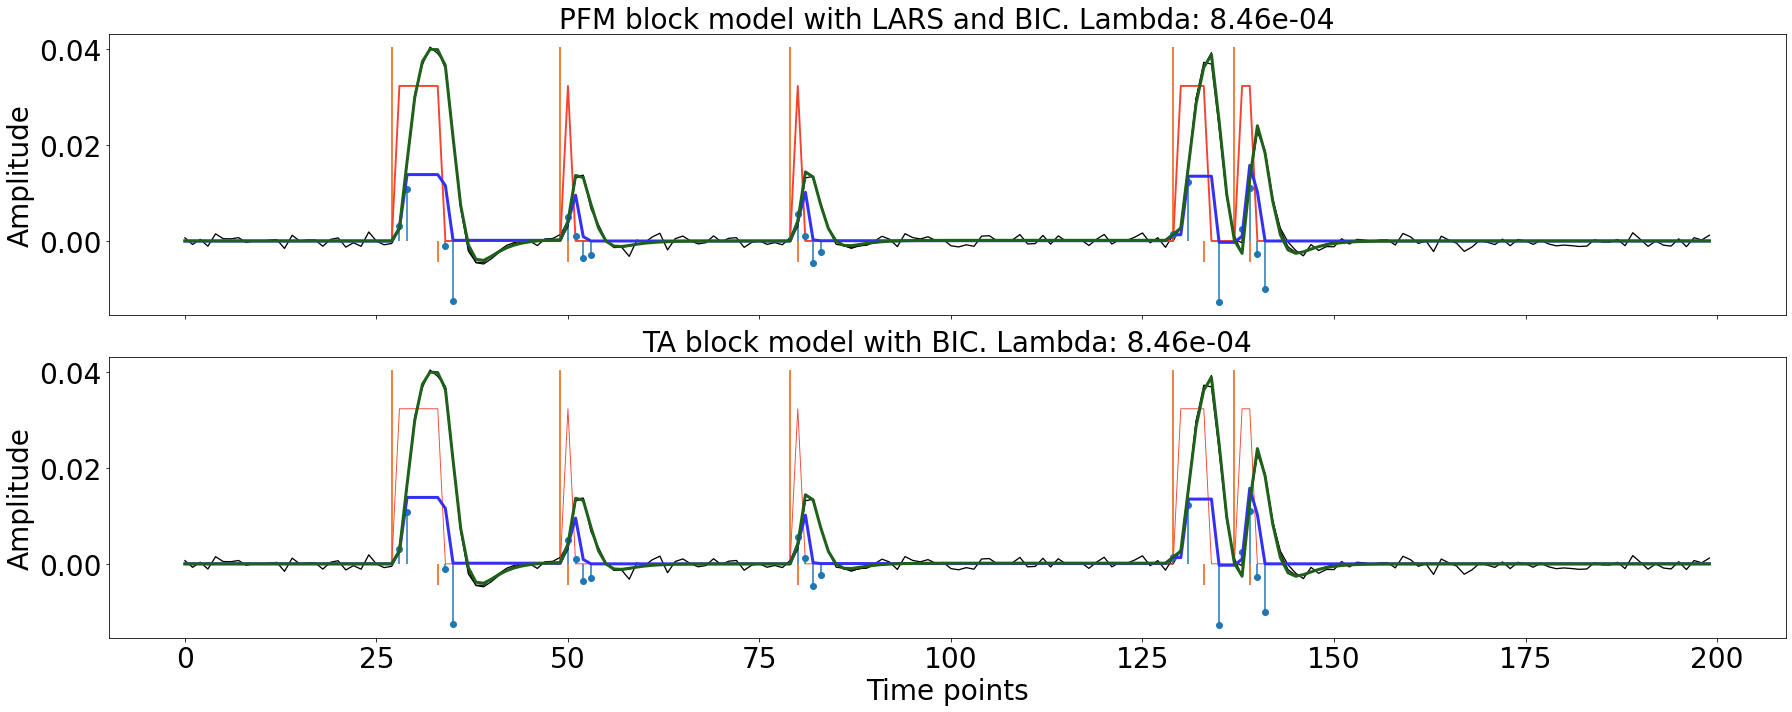

In [20]:
pfm_2_plot = pfm_block_coef_path[:,bic_pfm_block_idx]
ta_2_plot = ta_block_coef_path[:,bic_ta_block_idx]

pfm_2_plot_inno = pfm_2_plot.copy()
ta_2_plot_inno = ta_2_plot.copy()

# Debiasing to obtain activity inducing signal and fit.
pfm_2_plot_beta, _ = debiasing_int(pfm_2_plot_inno, hrf, data, True)
#pfm_2_plot_beta = np.dot(np.tril(np.ones(nscans)), pfm_2_plot_inno)
pfm_2_plot_fit = np.squeeze(np.dot(hrf, pfm_2_plot_beta))

# Obtain activity inducing signal and fit for TA. 
# ta_2_plot_beta = np.dot(np.tril(np.ones(nscans)), ta_2_plot_inno)
ta_2_plot_beta, _ = debiasing_int(ta_2_plot_inno, hrf, data, True)
ta_2_plot_fit = np.squeeze(np.dot(hrf, ta_2_plot_beta))
# ta_2_plot_fit = ta_block_fit[:,bic_ta_block_idx]

# NANs to avoid plotting zeros with stem.
pfm_2_plot_inno[abs(pfm_2_plot_inno) < min_coeff_amplitude] = np.nan
ta_2_plot_inno[abs(ta_2_plot_inno) < min_coeff_amplitude] = np.nan

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(25,10))
ax1.plot(y, color='black', linewidth=1.3, label='Simulation')
ax1.plot(ground_truth_bold, color='black', linewidth=1.3, label='Ground truth BOLD')
ax1.vlines(np.where(ground_truth_inno > 0)[0], ymin=0, ymax=np.max(data), color='#f17c37', linewidth=1.9, label='Ground truth inno')
ax1.vlines(np.where(ground_truth_inno < 0)[0], ymin=np.min(data), ymax=0, color='#f17c37', linewidth=1.9)
ax1.plot(ground_truth_beta*np.max(data)*0.8, color='#f74231', linewidth=1.9, label='Ground truth beta')
ax1.stem(pfm_2_plot_inno, label='PFM inno', use_line_collection=True, basefmt=" ")
ax1.plot(pfm_2_plot_beta, color='#3431f7', label='PFM beta', linewidth=3)
ax1.plot(pfm_2_plot_fit, color='#1f611a', label='PFM fit', linewidth=3)
ax1.set(ylabel='Amplitude')
ax1.set_title('PFM block model with LARS and BIC. Lambda: {:.2e}'.format(lambdas_pfm_block[bic_pfm_block_idx]))
# ax1.legend()
ax2.plot(y, color='black', linewidth=1.3, label='Simulation')
ax2.plot(ground_truth_bold, color='black', linewidth=1.3, label='Ground truth BOLD')
ax2.vlines(np.where(ground_truth_inno > 0)[0], ymin=0, ymax=np.max(data), color='#f17c37', linewidth=1.9, label='Ground truth inno')
ax2.vlines(np.where(ground_truth_inno < 0)[0], ymin=np.min(data), ymax=0, color='#f17c37', linewidth=1.9)
ax2.plot(ground_truth_beta*np.max(data)*0.8, color='#f74231', linewidth=0.9, label='Ground truth beta')
ax2.stem(ta_2_plot_inno, label='TA inno', use_line_collection=True, basefmt=" ")
ax2.plot(ta_2_plot_beta, color='#3431f7', label='TA beta', linewidth=3)
ax2.plot(ta_2_plot_fit, color='#1f611a', label='TA fit', linewidth=3)
ax2.set(xlabel='Time points', ylabel='Amplitude')
ax2.set_title('TA block model with BIC. Lambda: {:.2e}'.format(lambdas_ta_block[bic_ta_block_idx]))
# ax2.legend()

plt.tight_layout()
plt.show()

## PFM vs TA with noise estimate and updating lambda (spike model)

In [21]:
# Generate hrf filter for TA with block model
params['model'] = 'spike'
params['f_analyze'], params['f_recons'], params['maxeig'] = hrf_filters(params['tr'], condition=params['model'])
n = params['f_analyze']['num']
d = params['f_analyze']['den']
params['NitTemp'] = 200

nlambdas = nscans

for vox_idx in range(1):
    y = data[:, vox_idx]
    y = y[:, np.newaxis]
    
    _, cD1 = wavedec(y, 'db3', level=1, axis=0)
    noise_estimate = np.median(abs(cD1 - np.median(cD1))) / 0.8095
    
    pfm_spikes, _, pfm_spike_last_lambda = fista(hrf, y, max_iter=1000, lambd=noise_estimate, update_lambda=True)
    ta_spikes, ta_spike_last_lambda = ta(y, params, lambd=noise_estimate, update_lambda=True)

    pfm_spikes[abs(pfm_spikes) < min_coeff_amplitude] = 0
    ta_spikes[abs(ta_spikes) < min_coeff_amplitude] = 0

/Users/enekourunuela/pfm_vs_ta/code/Scripts/total_activation.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  fil[i + 1] = (-1) ** (i + 1) * np.sum(np.exp(np.sum(combs_result, axis=1)))


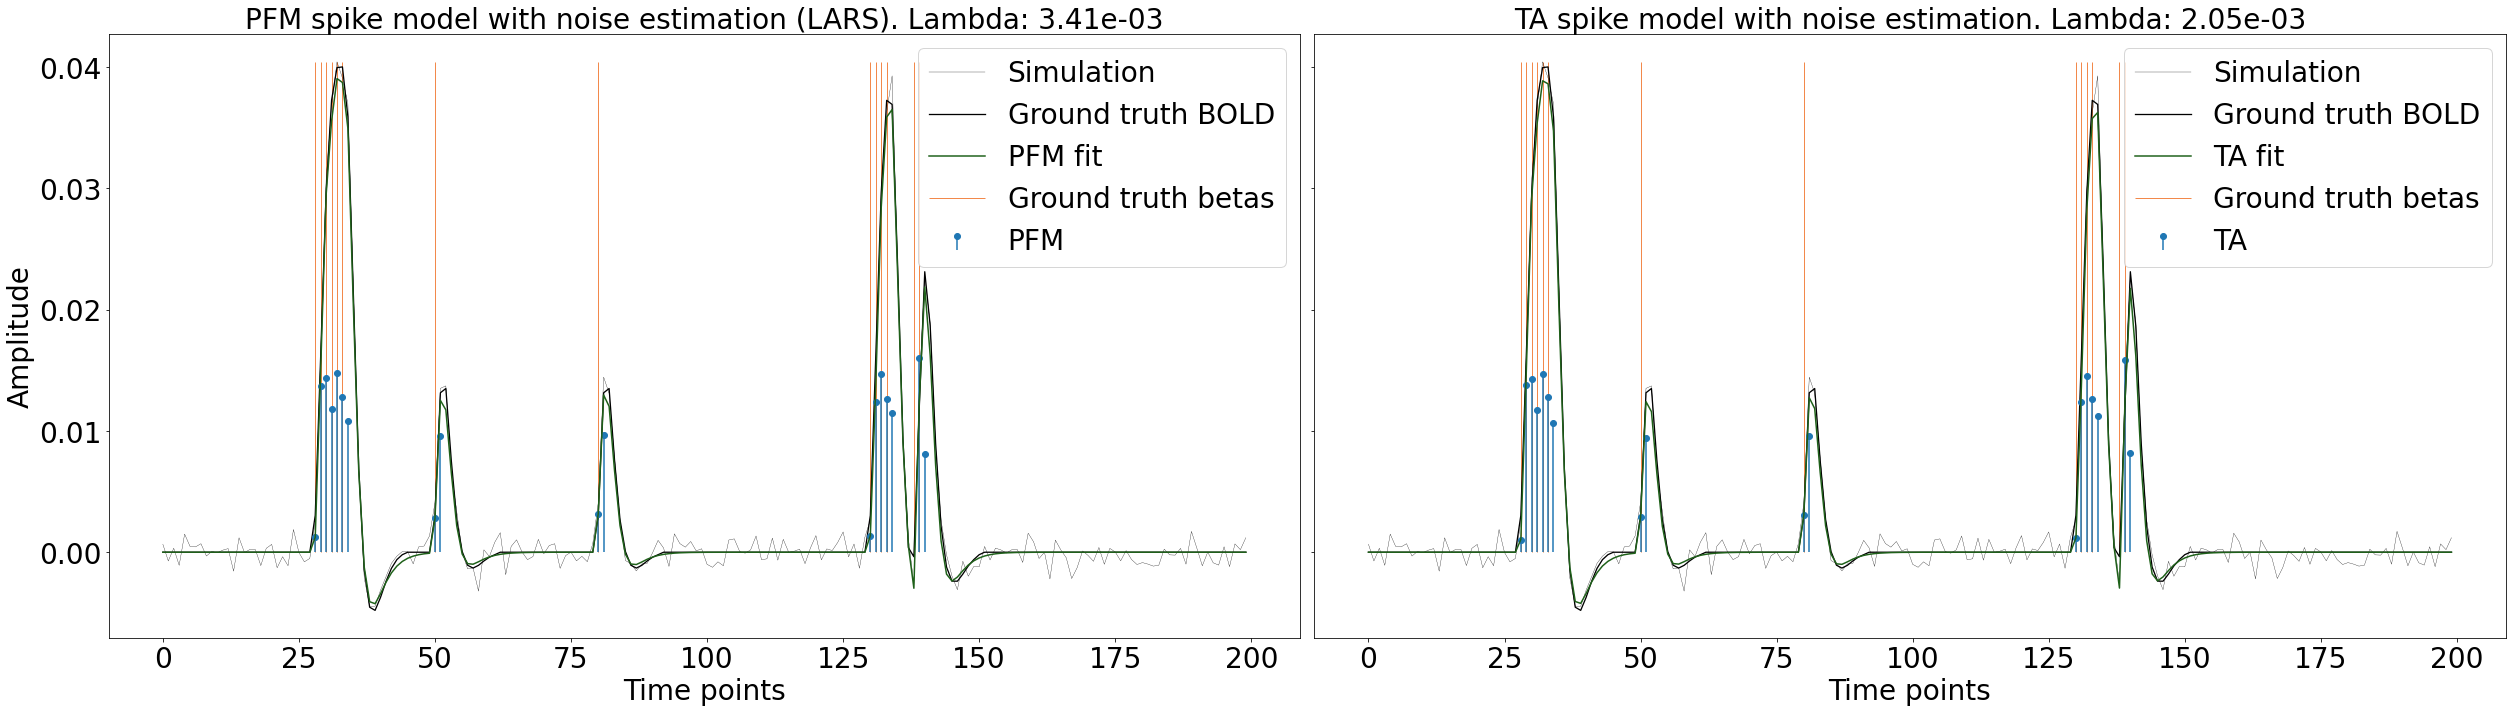

In [22]:
# Find optimal lambda on LARS and get coefficients
# Find optimal lambda on LARS and get coefficients
try:
    spike_lambda_idx = np.where(noise_estimate > np.sqrt(L2res_pfm_spike/nscans))[0][0]
    lars_2_plot = pfm_spike_coef_path[:, spike_lambda_idx]
except:
    lars_2_plot = pfm_spike_coef_path[:, -1]

# Get results
pfm_spikes_plot = pfm_spikes.copy()
lars_spikes_plot = lars_2_plot.copy()
ta_spikes_plot = ta_spikes.copy()

# Get fit.
pfm_2_plot_fit = np.dot(hrf, pfm_spikes_plot)
lars_2_plot_fit = np.dot(hrf, lars_spikes_plot)
ta_2_plot_fit = np.dot(hrf, ta_spikes_plot)

# Make zeros nan to avoid plotting them
pfm_spikes_plot[abs(pfm_spikes_plot) < min_coeff_amplitude] = np.nan
lars_spikes_plot[abs(lars_spikes_plot) < min_coeff_amplitude] = np.nan
ta_spikes_plot[abs(ta_spikes_plot) < min_coeff_amplitude] = np.nan

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(35,10))

ax1.plot(y, color='black', linewidth=.3, label='Simulation')
ax1.plot(ground_truth_bold, color='black', linewidth='1.3', label='Ground truth BOLD')
ax1.vlines(np.where(ground_truth_beta != 0)[0], ymin=0, ymax=np.max(data), color='#f17c37', linewidth=0.9, label='Ground truth betas')
ax1.stem(lars_spikes_plot, label='PFM', use_line_collection=True, basefmt=" ")
ax1.plot(lars_2_plot_fit, color='#1f611a', label='PFM fit')
ax1.set(xlabel='Time points', ylabel='Amplitude')
ax1.set_title('PFM spike model with noise estimation (LARS). Lambda: {:.2e}'.format(lambdas_pfm_spike[spike_lambda_idx]))
ax1.legend()

ax2.plot(y, color='black', linewidth=.3, label='Simulation')
ax2.plot(ground_truth_bold, color='black', linewidth='1.3', label='Ground truth BOLD')
ax2.vlines(np.where(ground_truth_beta != 0)[0], ymin=0, ymax=np.max(data), color='#f17c37', linewidth=0.9, label='Ground truth betas')
ax2.stem(ta_spikes_plot, label='TA', use_line_collection=True, basefmt=" ")
ax2.plot(ta_2_plot_fit, color='#1f611a', label='TA fit')
ax2.set(xlabel='Time points')
ax2.set_title('TA spike model with noise estimation. Lambda: {:.2e}'.format(ta_spike_last_lambda[0][0]))
ax2.legend()

plt.tight_layout()
plt.show()

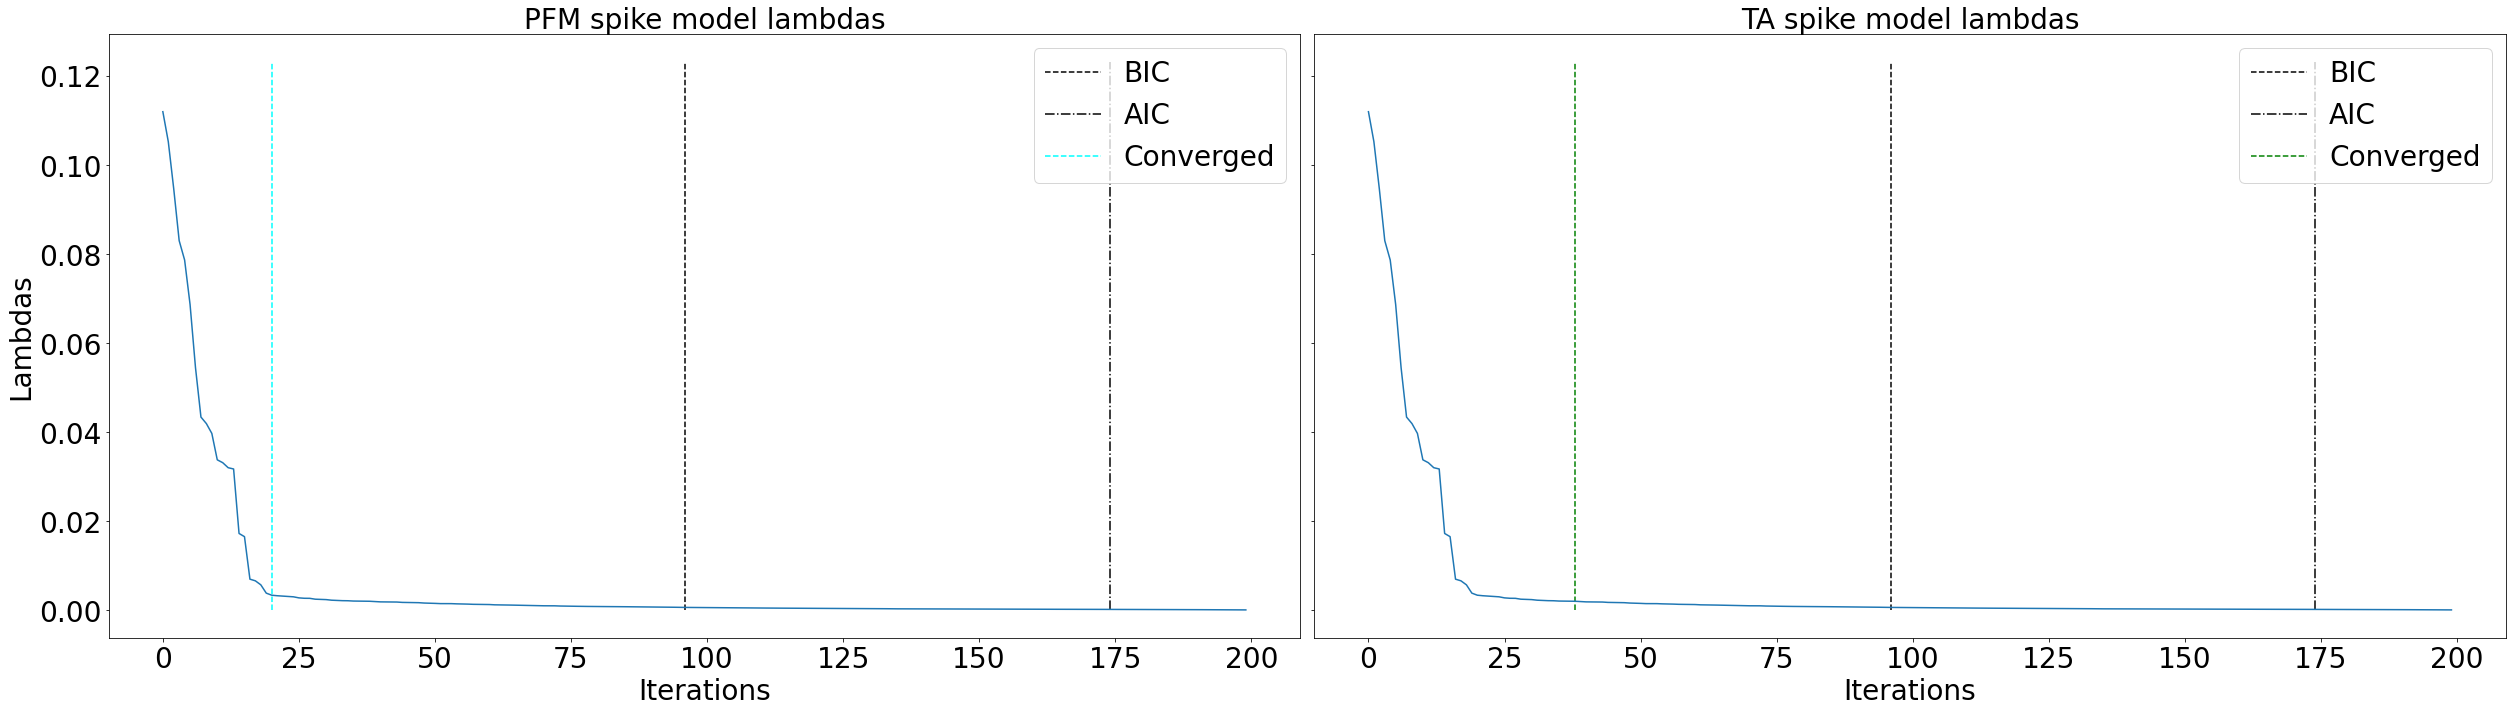

In [23]:
if pfm_spike_last_lambda[0] < lambdas_pfm_spike[-1]:
    pfm_converged_spike = lambdas_pfm_spike[-1]
    print('TA converged to a lambda that is lower in the regularization path...')
    print('Plotting last possible value of lambda instead.')
else:
    pfm_converged_spike = np.where(pfm_spike_last_lambda[0] > lambdas_pfm_spike)[0][0]

if ta_spike_last_lambda[0] < lambdas_ta_spike[-1]:
    ta_converged_spike = len(lambdas_ta_spike) - 1
    print('TA converged to a lambda that is lower in the regularization path...')
    print('Plotting last possible value of lambda instead.')
else:
    ta_converged_spike = np.where(ta_spike_last_lambda[0] > lambdas_ta_spike)[0][0]

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(35,10))
ax1.plot(lambdas_pfm_spike)
ax1.vlines(x=bic_pfm_spike_idx, ymin=0, ymax=1.1*np.max(lambdas_pfm_spike), color='black', linestyles='dashed', label='BIC')
ax1.vlines(x=aic_pfm_spike_idx, ymin=0, ymax=1.1*np.max(lambdas_pfm_spike), color='black', linestyles='dashdot', label='AIC')
ax1.vlines(x=spike_lambda_idx, ymin=0, ymax=1.1*np.max(lambdas_pfm_spike), color='cyan', linestyles='dashed', label='Converged')
ax1.legend()
ax1.set(xlabel='Iterations', ylabel='Lambdas')
ax1.set_title('PFM spike model lambdas')
ax2.plot(lambdas_ta_spike)
ax2.vlines(x=bic_ta_spike_idx, ymin=0, ymax=1.1*np.max(lambdas_ta_spike), color='black', linestyles='dashed', label='BIC')
ax2.vlines(x=aic_ta_spike_idx, ymin=0, ymax=1.1*np.max(lambdas_ta_spike), color='black', linestyles='dashdot', label='AIC')
ax2.vlines(x=ta_converged_spike, ymin=0, ymax=1.1*np.max(lambdas_ta_spike), color='green', linestyles='dashed', label='Converged')
ax2.legend()
ax2.set(xlabel='Iterations')
ax2.set_title('TA spike model lambdas')

plt.tight_layout()
plt.show()

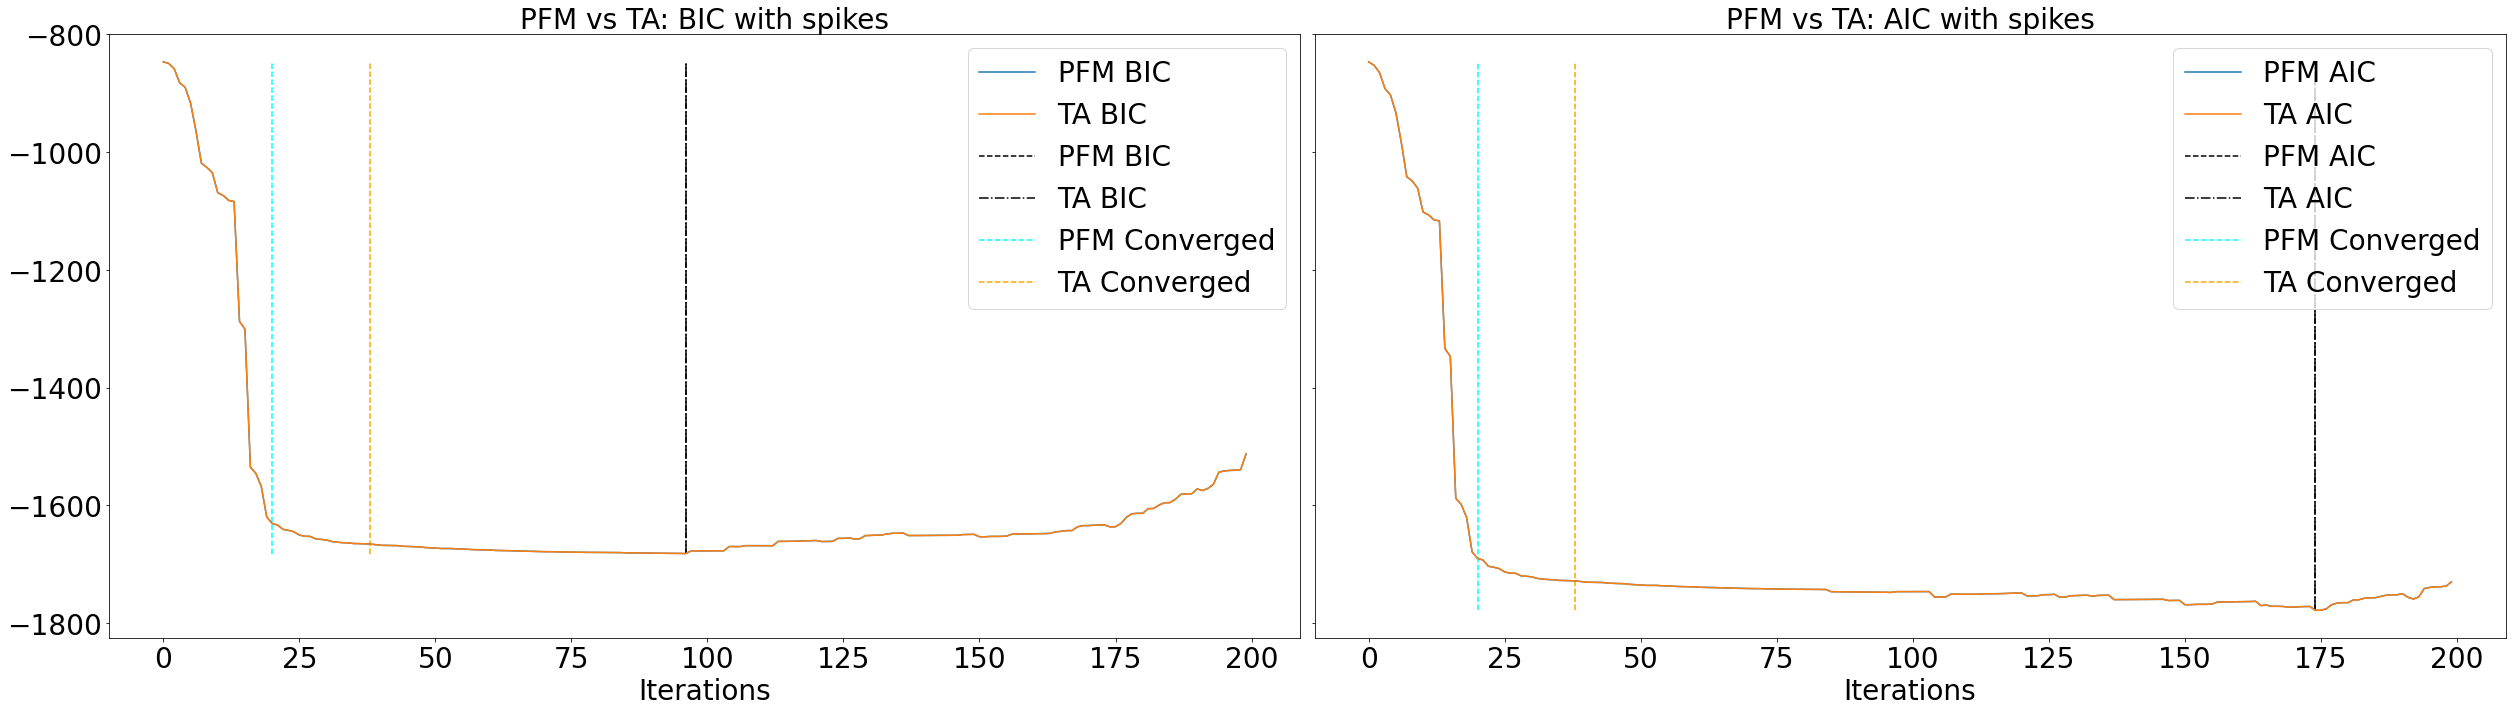

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(35,10))
ax1.plot(bic_pfm_spike, label='PFM BIC')
ax1.plot(bic_ta_spike, label='TA BIC')
ax1.vlines(x=bic_pfm_spike_idx, ymin=np.min(bic_pfm_spike), ymax=np.max(bic_pfm_spike), color='black', linestyles='dashed', label='PFM BIC')
ax1.vlines(x=bic_ta_spike_idx, ymin=np.min(bic_ta_spike), ymax=np.max(bic_ta_spike), color='black', linestyles='dashdot', label='TA BIC')
ax1.vlines(x=spike_lambda_idx, ymin=np.min(bic_pfm_spike), ymax=np.max(bic_pfm_spike), color='cyan', linestyles='dashed', label='PFM Converged')
ax1.vlines(x=ta_converged_spike, ymin=np.min(bic_ta_spike), ymax=np.max(bic_ta_spike), color='orange', linestyles='dashed', label='TA Converged')
ax1.set(xlabel='Iterations')
ax1.set_title('PFM vs TA: BIC with spikes')
ax1.legend()
ax2.plot(aic_pfm_spike, label='PFM AIC')
ax2.plot(aic_ta_spike, label='TA AIC')
ax2.vlines(x=aic_pfm_spike_idx, ymin=np.min(aic_pfm_spike), ymax=np.max(aic_pfm_spike), color='black', linestyles='dashed', label='PFM AIC')
ax2.vlines(x=aic_ta_spike_idx, ymin=np.min(aic_ta_spike), ymax=np.max(aic_ta_spike), color='black', linestyles='dashdot', label='TA AIC')
ax2.vlines(x=spike_lambda_idx, ymin=np.min(aic_pfm_spike), ymax=np.max(aic_pfm_spike), color='cyan', linestyles='dashed', label='PFM Converged')
ax2.vlines(x=ta_converged_spike, ymin=np.min(aic_ta_spike), ymax=np.max(aic_ta_spike), color='orange', linestyles='dashed', label='TA Converged')
ax2.set(xlabel='Iterations')
ax2.legend()
ax2.set_title('PFM vs TA: AIC with spikes')

plt.tight_layout()
plt.show()

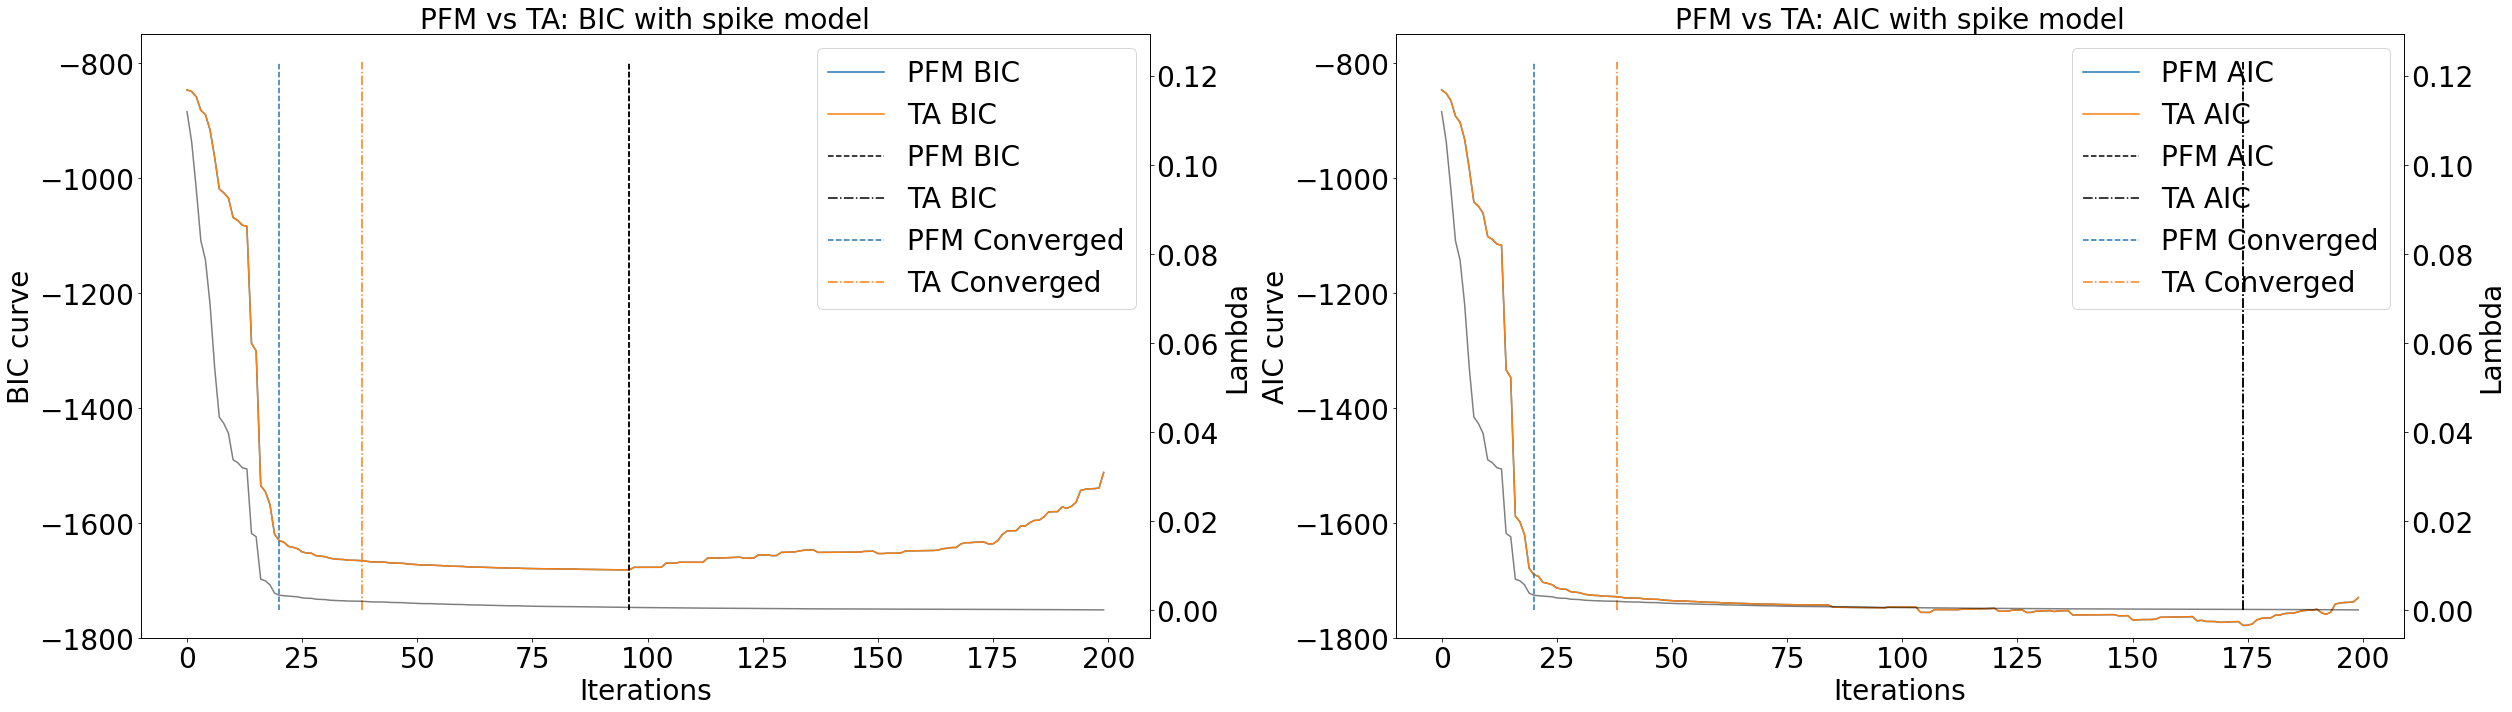

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(35,10))
ax1.plot(bic_pfm_spike, label='PFM BIC')
ax1.plot(bic_ta_spike, label='TA BIC')
ax1.vlines(x=bic_pfm_spike_idx, ymin=0, ymax=1.1*np.max(lambdas_pfm_spike), color='black', linestyles='dashed', label='PFM BIC')
ax1.vlines(x=bic_ta_spike_idx, ymin=0, ymax=1.1*np.max(lambdas_pfm_spike), color='black', linestyles='dashdot', label='TA BIC')
ax1.vlines(x=spike_lambda_idx, ymin=0, ymax=1.1*np.max(lambdas_pfm_spike), color='tab:blue', linestyles='dashed', label='PFM Converged')
ax1.vlines(x=ta_converged_spike, ymin=0, ymax=1.1*np.max(lambdas_pfm_spike), color='tab:orange', linestyles='dashdot', label='TA Converged')
ax1.set(xlabel='Iterations', ylabel='BIC curve')
ax1.set_title('PFM vs TA: BIC with spike model')
ax1.legend()
ax2.plot(aic_pfm_spike, label='PFM AIC')
ax2.plot(aic_ta_spike, label='TA AIC')
ax2.vlines(x=aic_pfm_spike_idx, ymin=0, ymax=1.1*np.max(lambdas_pfm_spike), color='black', linestyles='dashed', label='PFM AIC')
ax2.vlines(x=aic_ta_spike_idx, ymin=0, ymax=1.1*np.max(lambdas_pfm_spike), color='black', linestyles='dashdot', label='TA AIC')
ax2.vlines(x=spike_lambda_idx, ymin=0, ymax=1.1*np.max(lambdas_pfm_spike), color='tab:blue', linestyles='dashed', label='PFM Converged')
ax2.vlines(x=ta_converged_spike, ymin=0, ymax=1.1*np.max(lambdas_pfm_spike), color='tab:orange', linestyles='dashdot', label='TA Converged')
ax2.set(xlabel='Iterations', ylabel='AIC curve')
ax2.legend()
ax2.set_title('PFM vs TA: AIC with spike model')

ax3 = ax1.twinx()
ax4 = ax2.twinx()
ax3.plot(lambdas_pfm_spike, color='black', alpha=0.5)
ax3.vlines(x=bic_pfm_spike_idx, ymin=0, ymax=1.1*np.max(lambdas_pfm_spike), color='black', linestyles='dashed', label='PFM BIC')
ax3.vlines(x=bic_ta_spike_idx, ymin=0, ymax=1.1*np.max(lambdas_ta_spike), color='black', linestyles='dashed', label='TA BIC')
ax3.vlines(x=spike_lambda_idx, ymin=0, ymax=1.1*np.max(lambdas_pfm_spike), color='tab:blue', linestyles='dashed', label='PFM Converged')
ax3.vlines(x=ta_converged_spike, ymin=0, ymax=1.1*np.max(lambdas_pfm_spike), color='tab:orange', linestyles='dashdot', label='TA Converged')
ax3.set(ylabel='Lambda')

ax4.plot(lambdas_ta_spike, color='black', alpha=0.5)
ax4.vlines(x=aic_pfm_spike_idx, ymin=0, ymax=1.1*np.max(lambdas_pfm_spike), color='black', linestyles='dashdot', label='PFM AIC')
ax4.vlines(x=aic_ta_spike_idx, ymin=0, ymax=1.1*np.max(lambdas_ta_spike), color='black', linestyles='dashdot', label='TA AIC')
ax4.vlines(x=spike_lambda_idx, ymin=0, ymax=1.1*np.max(lambdas_pfm_spike), color='tab:blue', linestyles='dashed', label='PFM Converged')
ax4.vlines(x=ta_converged_spike, ymin=0, ymax=1.1*np.max(lambdas_pfm_spike), color='tab:orange', linestyles='dashdot', label='TA Converged')
ax4.set(ylabel='Lambda')

ax1.set_ylim([-1800, -750])
ax2.set_ylim([-1800, -750])

plt.tight_layout()
plt.show()

## PFM vs TA with noise estimate and updating lambda (block model)
### Instead of using model selection criteria (e.g. BIC, AIC) to select the regularization parameter, we can make the algorithm converge to a regularization parameter (lambda) such that the standard deviation of the residuals is equal to an estimation of the standand deviation of the additive noise in the original time series, which is defined as the MAD estimate after wavelet decomposition. This is the approach proposed in the original TA paper. 


In [26]:
# Generate hrf filter for TA with block model
params['model'] = 'block'
params['f_analyze'], params['f_recons'], params['maxeig'] = hrf_filters(params['tr'], condition=params['model'])
n = params['f_analyze']['num']
d = params['f_analyze']['den']
params['NitTemp'] = 1000

nlambdas = nscans

for vox_idx in range(1):
    y = data[:, vox_idx]
    y = y[:, np.newaxis]
    
    _, cD1 = wavedec(y, 'db3', level=1, axis=0)
    noise_estimate = np.median(abs(cD1 - np.median(cD1))) / 0.8095
    
    pfm_block, _, pfm_block_last_lambda = fista(hrf_block, y, max_iter=1000, lambd=noise_estimate, update_lambda=True)
    ta_block, ta_block_last_lambda = ta(y, params, lambd=noise_estimate, update_lambda=True)

    pfm_block[abs(pfm_block) < min_coeff_amplitude] = 0
    ta_block[abs(ta_block) < min_coeff_amplitude] = 0


/Users/enekourunuela/pfm_vs_ta/code/Scripts/total_activation.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  fil[i + 1] = (-1) ** (i + 1) * np.sum(np.exp(np.sum(combs_result, axis=1)))


## Due to the smoothness of the HRF, there are correlation between successive coefficients. In order to be more precise in the localization of the effects, we only keep the peaks when multiple successive coefficients are non-zero. 

In [27]:
# Only keep peaks
pfm_block = np.squeeze(pfm_block)
peak_idxs, _ = find_peaks(abs(pfm_block), prominence=np.max(pfm_block)*0.01, distance=5)
temp = np.zeros((pfm_block.shape[0],))
temp[peak_idxs] = pfm_block[peak_idxs].copy()

ta_block = np.squeeze(ta_block)
ta_peak_idxs, _ = find_peaks(abs(ta_block), prominence=np.max(ta_block)*0.01, distance=5)
ta_temp = np.zeros((ta_block.shape[0],))
ta_temp[ta_peak_idxs] = ta_block[ta_peak_idxs].copy()

TypeError: unsupported format string passed to numpy.ndarray.__format__

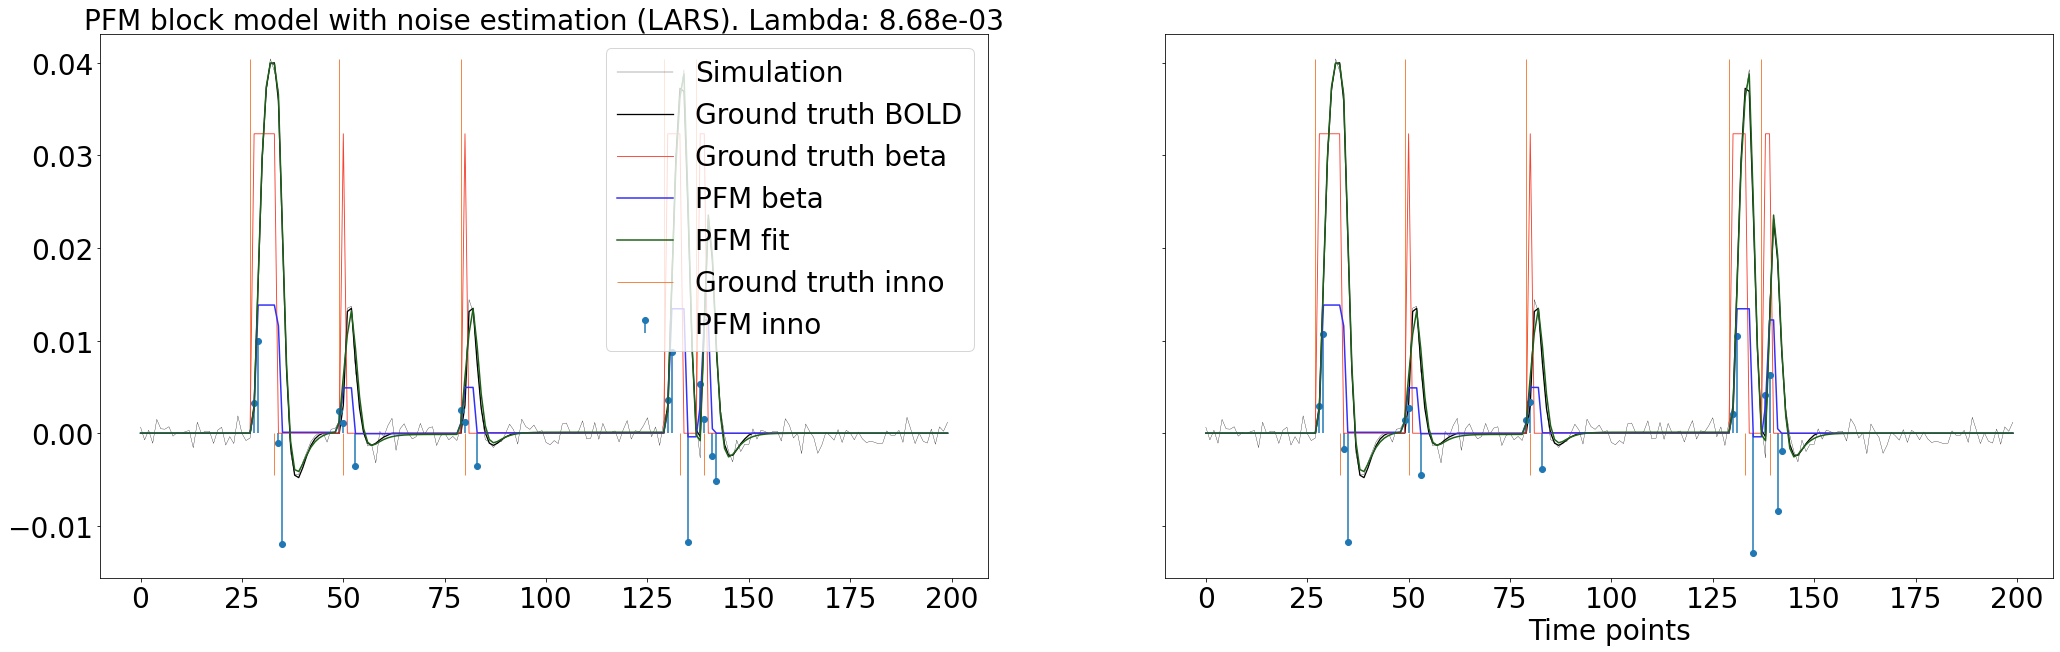

In [28]:
# Find optimal lambda on LARS and get coefficients
try:
    block_lambda_idx = np.where(noise_estimate > np.sqrt(L2res_pfm_block/nscans))[0][0]
    lars_2_plot = pfm_block_coef_path[:, block_lambda_idx]
except:
    block_lambda_idx = pfm_block_coef_path.shape[1] - 1
    lars_2_plot = pfm_block_coef_path[:, -1]

# Get results
pfm_2_plot_inno = pfm_block.copy()
lars_2_plot_inno = lars_2_plot.copy()
ta_2_plot_inno = ta_block.copy()

# Debiasing to obtain activity inducing signal and fit.
lars_2_plot_beta, _ = debiasing_int(pfm_block_coef_path[:, block_lambda_idx], hrf, data, True)
lars_2_plot_fit = np.squeeze(np.dot(hrf, lars_2_plot_beta))

ta_2_plot_beta, _ = debiasing_int(ta_2_plot_inno, hrf, data, True)
#ta_2_plot_beta = np.dot(np.tril(np.ones(nscans)), ta_block)
ta_2_plot_fit = np.squeeze(np.dot(hrf, ta_2_plot_beta))

# NANs to avoid plotting zeros with stem.
lars_2_plot_inno[abs(lars_2_plot_inno) < min_coeff_amplitude] = np.nan
ta_2_plot_inno[abs(ta_2_plot_inno) < min_coeff_amplitude] = np.nan

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(35,10))

ax1.plot(y, color='black', linewidth=.3, label='Simulation')
ax1.plot(ground_truth_bold, color='black', linewidth='1.3', label='Ground truth BOLD')
ax1.vlines(np.where(ground_truth_inno > 0)[0], ymin=0, ymax=np.max(data), color='#f17c37', linewidth=0.9, label='Ground truth inno')
ax1.vlines(np.where(ground_truth_inno < 0)[0], ymin=np.min(data), ymax=0, color='#f17c37', linewidth=0.9)
ax1.plot(ground_truth_beta*np.max(data)*0.8, color='#f74231', linewidth=0.9, label='Ground truth beta')
ax1.stem(lars_2_plot_inno, label='PFM inno', use_line_collection=True, basefmt=" ")
ax1.plot(lars_2_plot_beta, color='#3431f7', label='PFM beta')
ax1.plot(lars_2_plot_fit, color='#1f611a', label='PFM fit')
ax1.set_title('PFM block model with noise estimation (LARS). Lambda: {:.2e}'.format(lambdas_pfm_block[block_lambda_idx]))
ax1.legend()

ax2.plot(y, color='black', linewidth=.3, label='Simulation')
ax2.plot(ground_truth_bold, color='black', linewidth='1.3', label='Ground truth BOLD')
ax2.vlines(np.where(ground_truth_inno > 0)[0], ymin=0, ymax=np.max(data), color='#f17c37', linewidth=0.9, label='Ground truth inno')
ax2.vlines(np.where(ground_truth_inno < 0)[0], ymin=np.min(data), ymax=0, color='#f17c37', linewidth=0.9)
ax2.plot(ground_truth_beta*np.max(data)*0.8, color='#f74231', linewidth=0.9, label='Ground truth beta')
ax2.stem(ta_2_plot_inno, label='TA inno', use_line_collection=True, basefmt=" ")
ax2.plot(ta_2_plot_beta, color='#3431f7', label='TA beta')
ax2.plot(ta_2_plot_fit, color='#1f611a', label='TA fit')
ax2.set(xlabel='Time points')
ax2.set_title('TA block model with noise estimation. Lambda: {:.2e}'.format(ta_block_last_lambda[0]))
ax2.legend()

plt.tight_layout()
plt.show()

In [ ]:
if pfm_block_last_lambda[0] < lambdas_pfm_block[-1]:
    pfm_converged_block = lambdas_pfm_block[-1]
    print('TA converged to a lambda that is lower in the regularization path...')
    print('Plotting last possible value of lambda instead.')
else:
    pfm_converged_block = np.where(pfm_block_last_lambda[0] > lambdas_pfm_block)[0][0]

if ta_block_last_lambda[0] < lambdas_ta_block[-1]:
    ta_converged_block = len(lambdas_ta_block) - 1
    print('TA converged to a lambda that is lower in the regularization path...')
    print('Plotting last possible value of lambda instead.')
else:
    ta_converged_block = np.where(ta_block_last_lambda[0] > lambdas_ta_block)[0][0]

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(35,10))
ax1.plot(lambdas_pfm_block)
ax1.vlines(x=bic_pfm_block_idx, ymin=0, ymax=1.1*np.max(lambdas_pfm_block), color='black', linestyles='dashed', label='BIC')
ax1.vlines(x=aic_pfm_block_idx, ymin=0, ymax=1.1*np.max(lambdas_pfm_block), color='black', linestyles='dashdot', label='AIC')
ax1.vlines(x=block_lambda_idx, ymin=0, ymax=1.1*np.max(lambdas_pfm_block), color='cyan', linestyles='dashed', label='Converged')
ax1.legend()
ax1.set(xlabel='Iterations', ylabel='Lambdas')
ax1.set_title('PFM block model lambdas')
ax2.plot(lambdas_ta_block)
ax2.vlines(x=bic_ta_block_idx, ymin=0, ymax=1.1*np.max(lambdas_ta_block), color='black', linestyles='dashed', label='BIC')
ax2.vlines(x=aic_ta_block_idx, ymin=0, ymax=1.1*np.max(lambdas_ta_block), color='black', linestyles='dashdot', label='AIC')
ax2.vlines(x=ta_converged_block, ymin=0, ymax=1.1*np.max(lambdas_ta_block), color='green', linestyles='dashed', label='Converged')
ax2.legend()
ax2.set(xlabel='Iterations')
ax2.set_title('TA block model lambdas')

plt.tight_layout()
plt.show()

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(35,10))
ax1.plot(bic_pfm_block, label='PFM BIC')
ax1.plot(bic_ta_block, label='TA BIC')
ax1.vlines(x=bic_pfm_block_idx, ymin=np.min(bic_pfm_block), ymax=np.max(bic_pfm_block), color='black', linestyles='dashed', label='PFM BIC')
ax1.vlines(x=bic_ta_block_idx, ymin=np.min(bic_ta_block), ymax=np.max(bic_ta_block), color='black', linestyles='dashdot', label='TA BIC')
ax1.vlines(x=block_lambda_idx, ymin=np.min(bic_pfm_block), ymax=np.max(bic_pfm_block), color='cyan', linestyles='dashed', label='PFM Converged')
ax1.vlines(x=ta_converged_block, ymin=np.min(bic_ta_block), ymax=np.max(bic_pfm_block), color='orange', linestyles='dashed', label='TA Converged')
ax1.set(xlabel='Iterations')
ax1.set_title('PFM vs TA: BIC with blocks')
ax1.legend()
ax2.plot(aic_pfm_block, label='PFM AIC')
ax2.plot(aic_ta_block, label='TA AIC')
ax2.vlines(x=aic_pfm_block_idx, ymin=np.min(aic_pfm_block), ymax=np.max(aic_pfm_block), color='black', linestyles='dashed', label='PFM AIC')
ax2.vlines(x=aic_ta_block_idx, ymin=np.min(aic_ta_block), ymax=np.max(aic_ta_block), color='black', linestyles='dashdot', label='TA AIC')
ax2.vlines(x=block_lambda_idx, ymin=np.min(aic_pfm_block), ymax=np.max(aic_pfm_block), color='cyan', linestyles='dashed', label='PFM Converged')
ax2.vlines(x=ta_converged_block, ymin=np.min(aic_ta_block), ymax=np.max(aic_ta_block), color='orange', linestyles='dashed', label='TA Converged')
ax2.set(xlabel='Iterations')
ax2.legend()
ax2.set_title('PFM vs TA: AIC with blocks')

plt.tight_layout()
plt.show()

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(35,10))
ax1.plot(bic_pfm_block, label='PFM BIC')
ax1.plot(bic_ta_block, label='TA BIC')
ax1.vlines(x=bic_pfm_block_idx, ymin=0, ymax=1.1*np.max(lambdas_pfm_block), color='black', linestyles='dashed', label='PFM BIC')
ax1.vlines(x=bic_ta_block_idx, ymin=0, ymax=1.1*np.max(lambdas_ta_block), color='black', linestyles='dashdot', label='TA BIC')
ax1.vlines(x=block_lambda_idx, ymin=0, ymax=1.1*np.max(lambdas_pfm_block), color='tab:blue', linestyles='dashed', label='PFM Converged')
ax1.vlines(x=ta_converged_block, ymin=0, ymax=1.1*np.max(lambdas_pfm_block), color='tab:orange', linestyles='dashdot', label='TA Converged')
ax1.set(xlabel='Iterations', ylabel='BIC curve')
ax1.set_title('PFM vs TA: BIC with block model')
ax1.legend()
ax2.plot(aic_pfm_block, label='PFM AIC')
ax2.plot(aic_ta_block, label='TA AIC')
ax2.vlines(x=aic_pfm_block_idx, ymin=0, ymax=1.1*np.max(lambdas_pfm_block), color='black', linestyles='dashed', label='PFM AIC')
ax2.vlines(x=aic_ta_block_idx, ymin=0, ymax=1.1*np.max(lambdas_ta_block), color='black', linestyles='dashdot', label='TA AIC')
ax2.vlines(x=block_lambda_idx, ymin=0, ymax=1.1*np.max(lambdas_pfm_block), color='tab:blue', linestyles='dashed', label='PFM Converged')
ax2.vlines(x=ta_converged_block, ymin=0, ymax=1.1*np.max(lambdas_pfm_block), color='tab:orange', linestyles='dashed', label='TA Converged')
ax2.set(xlabel='Iterations', ylabel='AIC curve')
ax2.legend()
ax2.set_title('PFM vs TA: AIC with block model')

ax3 = ax1.twinx()
ax4 = ax2.twinx()
ax3.plot(lambdas_pfm_block, color='black', alpha=0.5)
ax3.vlines(x=bic_pfm_block_idx, ymin=0, ymax=1.1*np.max(lambdas_pfm_block), color='black', linestyles='dashed', label='PFM BIC')
ax3.vlines(x=bic_ta_block_idx, ymin=0, ymax=1.1*np.max(lambdas_ta_block), color='black', linestyles='dashdot', label='TA BIC')
ax3.vlines(x=block_lambda_idx, ymin=0, ymax=1.1*np.max(lambdas_ta_block), color='tab:blue', linestyles='dashed', label='PFM Converged')
ax3.vlines(x=ta_converged_block, ymin=0, ymax=1.1*np.max(lambdas_ta_block), color='tab:orange', linestyles='dashdot', label='TA Converged')
ax3.set(ylabel='Lambda')

ax4.plot(lambdas_ta_block, color='black', alpha=0.5)
ax4.vlines(x=aic_pfm_block_idx, ymin=0, ymax=1.1*np.max(lambdas_pfm_block), color='black', linestyles='dashed', label='PFM AIC')
ax4.vlines(x=aic_ta_block_idx, ymin=0, ymax=1.1*np.max(lambdas_ta_block), color='black', linestyles='dashdot', label='TA AIC')
ax4.vlines(x=block_lambda_idx, ymin=0, ymax=1.1*np.max(lambdas_ta_block), color='tab:blue', linestyles='dashed', label='PFM Converged')
ax4.vlines(x=ta_converged_block, ymin=0, ymax=1.1*np.max(lambdas_ta_block), color='tab:orange', linestyles='dashed', label='TA Converged')
ax4.set(ylabel='Lambda')

ax1.set_ylim([-1800, -750])
ax2.set_ylim([-1800, -750])

plt.tight_layout()
plt.show()